# AMORE Project 
### Evaluation of the Automated Model Reduction (AMORE) Isoprene Chemical Mechanism in GEOS-Chem
## By Benjamin Yang

In [1]:
# Import modules
import os
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, date, time, timedelta
from dateutil.relativedelta import relativedelta
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
from matplotlib import dates
from matplotlib.patches import Polygon
import re
import glob
from sklearn import metrics
from scipy import stats
import seaborn as sns
%matplotlib inline
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
mpl.rcParams['mathtext.default'] = 'regular' # no italics

In [2]:
# Get all dates between start and end dates inclusive
def date_range(start, end, delta):
    curr = start
    while curr <= end:
        yield curr
        curr += delta

# Create a directory (equivalent to using mkdir -p on the command line)
def mkdir_p(mypath):
    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

# Compute mean absolute error (MAE)
def get_mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

# Compute root mean squared error (RMSE)
def get_rmse(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.sqrt(((y_true - predictions) ** 2).mean())

# Compute normalized mean bias (NMB)
def get_nmb(y_true,predictions):  
    y_true, predictions = np.array(y_true), np.array(predictions)
    return (predictions-y_true).sum()/y_true.sum()

# Get meteorological season based on month
def get_season(month):
    if (month == 12 or 1 <= month <= 2):
        return 'DJF'  # winter   
    elif (3 <= month <= 5):
        return 'MAM'  # spring
    elif (6 <= month <= 8):
        return 'JJA'  # summer
    else:
        return 'SON'  # fall

# Read latitude and longitude from file into numpy arrays
def naive_fast(latvar,lonvar,lat0,lon0):
    latvals = latvar[:]
    lonvals = lonvar[:]
    ny,nx = latvals.shape
    dist_sq = (latvals-lat0)**2 + (lonvals-lon0)**2
    minindex_flattened = dist_sq.argmin()  # 1D index of min element
    iy_min,ix_min = np.unravel_index(minindex_flattened, latvals.shape)
    return int(iy_min),int(ix_min)    

# Enter start and end dates
start = date(2018,1,1)
end = date(2018,12,31)

# Save all-inclusive dates to a list
alldates=[]
for result in date_range(start, end, relativedelta(months=1)):
    alldates.append(result.strftime('%Y%m'))
alldates

['201801',
 '201802',
 '201803',
 '201804',
 '201805',
 '201806',
 '201807',
 '201808',
 '201809',
 '201810',
 '201811',
 '201812']

In [3]:
# Define paths of data and figure directories
data_dir = '/data0/byang/amore_v4/' # AMORE
data_dir2 = '/data0/byang/gc_merra2_fullchem_complexSOA_SVPOA/' # BASE
data_dir3 = '/data0/byang/gc_merra2_fullchem_complexSOA_SVPOA_zUS_ISOP/' # BASE zUS_ISOP 
data_dir4 = '/data0/byang/amore_zUS_ISOP/' # AMORE zUS_ISOP 
data_dir5 = '/data0/byang/gc_merra2_fullchem_complexSOA_SVPOA_zUS_ANTH/' # BASE zUS_ANTH 
data_dir6 = '/data0/byang/amore_zUS_ANTH/' # AMORE zUS_ANTH 
data_dir7 = '/data0/byang/gc_merra2_fullchem_complexSOA_SVPOA_zUS_ISOP_ANTH/' # BASE zUS_ISOP_ANTH 
data_dir8 = '/data0/byang/amore_zUS_ISOP_ANTH/' # AMORE zUS_ISOP_ANTH 
data_dir9 = '/data0/byang/gc_merra2_fullchem_complexSOA_SVPOA_zGLB_ANTH/' # BASE zGLB_ANTH 
data_dir10 = '/data0/byang/amore_zGLB_ANTH/' # AMORE zGLB_ANTH 
data_dir11 = '/data0/byang/gc_geosfp_fullchem_complexSOA_SVPOA_US/' # BASE_HR
data_dir12 = '/data0/byang/amore_geosfp_highres/' # AMORE_HR
fig_dir = '/home/byang/output/amore/' # figures
obs_dir = '/home/byang/data/' # observational data
all_data_dir = [data_dir,data_dir2,data_dir3,data_dir4,data_dir5,data_dir6,data_dir7,data_dir8,data_dir9,data_dir10,data_dir11,data_dir12] # all 12 GEOS-Chem simulations

In [38]:
# Load AQS data from csv files
#colnames=['LAT', 'LON', 'DATETIME', 'PARAM', 'PM2.5', 'UNITS']
usecol = ['Latitude','Longitude','Parameter Name','Sample Duration','Date Local','Arithmetic Mean','Observation Percent']
aqs = []
for f in aqs_path:
    df = pd.read_csv(f,usecols=usecol)
    df = df[df['Arithmetic Mean']>=0] # remove negative values
    # Get lat/lon in SE US study area (bounding box values included by default)
    #df = df[df['Latitude'].between(24,49) & df['Longitude'].between(-100,-66)] 
    df = df[df['Latitude'].between(27,46) & df['Longitude'].between(-97,-69)] # remove buffer zone (3 deg)
    aqs.append(df)

In [39]:
# Combine data from different files into one dataframe 
aqs = pd.concat(aqs)
aqs

,Latitude,Longitude,Parameter Name,Sample Duration,Date Local,Observation Percent,Arithmetic Mean
0,33.553056,-86.81500,Reactive oxides of nitrogen (NOy),1 HOUR,2018-01-01,100.0,4.450000
1,33.553056,-86.81500,Reactive oxides of nitrogen (NOy),1 HOUR,2018-01-02,100.0,8.975000
2,33.553056,-86.81500,Reactive oxides of nitrogen (NOy),1 HOUR,2018-01-03,100.0,10.787500
3,33.553056,-86.81500,Reactive oxides of nitrogen (NOy),1 HOUR,2018-01-04,92.0,7.859091
4,33.553056,-86.81500,Reactive oxides of nitrogen (NOy),1 HOUR,2018-01-05,92.0,25.395455
...,...,...,...,...,...,...,...
808616,43.017240,-87.93369,"1,4-Dichlorobenzene",24 HOUR,2018-12-04,100.0,0.100000
808617,43.017240,-87.93369,"1,4-Dichlorobenzene",24 HOUR,2018-12-10,100.0,0.100000
808618,43.017240,-87.93369,"1,4-Dichlorobenzene",24 HOUR,2018-12-16,100.0,0.200000
808619,43.017240,-87.93369,"1,4-Dichlorobenzene",24 HOUR,2018-12-22,100.0,0.100000


In [41]:
# Load IMPROVE data from txt file
df = pd.read_csv(obs_dir+'AQS/improve_oc_2018.txt',delimiter='\s+')
df = df[df['OCf_Val']>=0] # remove negative values
# Get lat/lon in SE US study area (bounding box values included by default)
#improve = df[df['Latitude'].between(24,49) & df['Longitude'].between(-100,-66)]
improve = df[df['Latitude'].between(27,46) & df['Longitude'].between(-97,-69)] # remove buffer zone (3 deg)
improve

,Dataset,SiteCode,POC,Date,AuxID,Latitude,Longitude,OCf_Val
203,IMPAER,ATLA1,1,01/02/2018,0,33.688,-84.2903,2.84584
204,IMPAER,ATLA1,1,01/05/2018,0,33.688,-84.2903,1.22763
205,IMPAER,ATLA1,1,01/08/2018,0,33.688,-84.2903,2.61273
206,IMPAER,ATLA1,1,01/11/2018,0,33.688,-84.2903,1.24471
207,IMPAER,ATLA1,1,01/14/2018,0,33.688,-84.2903,1.75083
...,...,...,...,...,...,...,...,...
17671,IMPAER,VILA1,1,12/13/2018,0,40.969,-95.0450,0.64904
17672,IMPAER,VILA1,1,12/16/2018,0,40.969,-95.0450,0.45662
17673,IMPAER,VILA1,1,12/19/2018,0,40.969,-95.0450,1.12156
17674,IMPAER,VILA1,1,12/22/2018,0,40.969,-95.0450,0.40384


In [42]:
# Select variables
var_all = ['PM25','SpeciesConc_O3','SpeciesConc_NO','SpeciesConc_NO2','SpeciesConc_CH2O','SpeciesConc_ISOP','TotalOC']
obs_df = {}
for v in var_all:
    print(v)
    if v == 'PM25':
        var_obs = aqs[(aqs['Parameter Name']=='PM2.5 - Local Conditions')] # ug m-3
        var_obs = var_obs[var_obs['Sample Duration']!='1 HOUR'] # 24 HOUR or 24-HR BLK AVG only
    if v == 'SpeciesConc_O3':
        var_obs = aqs[aqs['Parameter Name']=='Ozone']
        var_obs = var_obs[var_obs['Observation Percent']==100]
        var_obs['Arithmetic Mean'] = var_obs['Arithmetic Mean']*1e3 # ppm to ppb
    if v == 'SpeciesConc_NO':
        var_obs = aqs[aqs['Parameter Name']=='Nitric oxide (NO)'] # ppb
        var_obs = var_obs[var_obs['Observation Percent']==100]
        no_obs = var_obs
    if v == 'SpeciesConc_NO2': 
        var_obs = aqs[aqs['Parameter Name']=='Oxides of nitrogen (NOx)'] # NOx (ppb)
        var_obs = var_obs[var_obs['Observation Percent']==100]
        var_obs['Date Local'] = pd.to_datetime(var_obs['Date Local'])
        var_obs = pd.merge(var_obs,no_obs,on=['Latitude','Longitude','Date Local']) # combine NO and NOx dataframes
        var_obs['Arithmetic Mean'] = var_obs['Arithmetic Mean_x'] - var_obs['Arithmetic Mean_y'] # NO2 = NOx - NO
    if v == 'SpeciesConc_CH2O':
        var_obs = aqs[aqs['Parameter Name']=='Formaldehyde'] # ppb
        var_obs = var_obs[var_obs['Sample Duration']=='24 HOUR'] # excluding 8 HOUR
        var_obs = var_obs[var_obs['Observation Percent']==100]
    if v == 'SpeciesConc_ISOP':
        var_obs = aqs[aqs['Parameter Name']=='Isoprene'] 
        var_obs = var_obs[var_obs['Sample Duration']=='24 HOUR'] # excluding 1 HOUR and 3 HOURS
        var_obs = var_obs[var_obs['Observation Percent']==100]
        var_obs['Arithmetic Mean'] = var_obs['Arithmetic Mean']/5 # ppbC to ppb
    if v == 'TotalOC':
        var_obs = improve # ug m-3
        var_obs = var_obs.rename(columns = {'Date':'Date Local','OCf_Val':'Arithmetic Mean'})
    var_obs['Date Local'] = pd.to_datetime(var_obs['Date Local'])
    var_obs = var_obs.groupby(['Latitude','Longitude',var_obs['Date Local'].dt.strftime('%Y%m')])['Arithmetic Mean'].mean().reset_index()
    obs_df[v] = var_obs

PM25
SpeciesConc_O3
SpeciesConc_NO
SpeciesConc_NO2
SpeciesConc_CH2O
SpeciesConc_ISOP
TotalOC


### Skip and run "grid_amf_sw_swp.py" (~68 hours)

In [4]:
# Get 1D arrays of lat/lon from OMI L3 NO2 and HCHO files
nc0 = Dataset(obs_dir+'OMI_VCD/EasternUS_OMI_monthlymean_NO2_2018.nc','r')
lat_no2 = nc0.variables['lat'][:] # 0.25 deg
lon_no2 = nc0.variables['lon'][:] # 0.25 deg
nc0.close()
nc0 = Dataset(obs_dir+'OMI_VCD/EasternUS_OMI_monthlymean_HCHO_2018.nc','r')
lat_hcho = nc0.variables['lat'][:] # 0.1 deg
lon_hcho = nc0.variables['lon'][:] # 0.1 deg
nc0.close()

In [ ]:
# Save all-inclusive dates to a list
alldates2=[]
for result in date_range(start, end, relativedelta(days=1)):
    alldates2.append(result.strftime('%m%d'))
#alldates2

In [ ]:
# Build 2D grids (rows = lat, cols = lon) for AMF_m, SW_m, and SWP_m
amf_grid_all = [] # month=12,species=2,lat=108/270,lon=144/360
sw_grid_all = [] # month=12,species=2,lat=108/270,lon=144/360,lev=35/47
swp_grid_all = [] # month=12,lat=270,lon=360,lev=47 (HCHO only)
species = ['NO2','HCHO']
slat = [lat_no2,lat_hcho]
slon = [lon_no2,lon_hcho]
slev = [35,47] # number of vertical pressure levels [NO2,HCHO]
for d in alldates: # loop over months in 2018
    #print(d)
    amf_grid_m = [[],[]]
    sw_grid_m = [[],[]]
    swp_grid_m = []
    mdates = [d2 for d2 in alldates2 if d2.startswith(d[4:])]   
    for s,ss in enumerate(species): # loop over each species
        #dd = mdates[0]
        for dd in mdates: # loop over days in given month
            #print(dd)
            rows = len(slat[s])
            columns= len(slon[s])
            amf_grid = [[np.nan for x in range(columns)] for x in range(rows)]
            sw_grid = [[[np.nan]*slev[s] for x in range(columns)] for x in range(rows)]
            swp_grid = [[[np.nan]*slev[s] for x in range(columns)] for x in range(rows)]

            # Create sorted list of OMI swath files for given day
            omi_path = sorted(glob.glob('/data0/byang/OMI_VCD/OMI_%s_L2/OMI-Aura_L2-OM%s_2018m%s*'%(ss,ss,dd)))
            if not omi_path: # if files are missing for given day (skip)
                print('Missing '+dd)
                continue

            lat = []
            lon = []
            amf = []
            sw = []
            swp = []
            for o in omi_path: # loop over swaths for given day
                # Read in data variables
                hdf = Dataset(o,'r')
                if ss=='NO2':
                    var = hdf.groups['HDFEOS'].groups['SWATHS'].groups['ColumnAmountNO2']
                    lat.append(var.groups['Geolocation Fields']['Latitude'][:]) # Latitude of the center of the groundpixel (degrees N) (dimensions: nTimes=1644, nXtrack=60)
                    lon.append(var.groups['Geolocation Fields']['Longitude'][:]) # Longitude of the center of the groundpixel (degrees E) (dimensions: nTimes=1644, nXtrack=60)
                    amf.append(var.groups['Data Fields']['AmfTrop'][:]) # Tropospheric air mass factor (dimensions: nTimes=1644, nXtrack=60)
                    sw.append(var.groups['Data Fields']['ScatteringWeight'][:]) # Scattering weight profile (nTimes=1644, nXtrack=60, nPresLevels=35)
                elif ss=='HCHO':
                    var = hdf.groups['HDFEOS'].groups['SWATHS'].groups['OMI Total Column Amount HCHO']
                    lat.append(var.groups['Geolocation Fields']['Latitude'][:]) # Geodetic Latitude (degrees N) (dimensions: nTimes=1644, nXtrack=60)
                    lon.append(var.groups['Geolocation Fields']['Longitude'][:]) # Geodetic Longitude (degrees E) (dimensions: nTimes=1644, nXtrack=60)
                    amf.append(var.groups['Data Fields']['AirMassFactor'][:]) # Molecule Specific Air Mass Factor (AMF) (dimensions: nTimes=1643, nXtrack=60)
                    sw.append(np.transpose(var.groups['Data Fields']['ScatteringWeights'][:],(1,2,0))) # Scattering Weights (nLevels=47, nTimes=1643, nXtrack=60)
                    swp.append(np.transpose(var.groups['Data Fields']['ClimatologyLevels'][:],(1,2,0))) # Climatology Levels (hPa) (nLevels=47, nTimes=1643, nXtrack=60)
                hdf.close()

            # Reshape 3d arrays into 2d (combine all swaths for given day)
            try: # if all swaths have same shape (faster)
                lat = np.reshape(lat,(1644*len(omi_path),60))
                lon = np.reshape(lon,(1644*len(omi_path),60))
                amf = np.reshape(amf,(1644*len(omi_path),60))
                sw = np.reshape(sw,(1644*len(omi_path),60,slev[s]))
            except: # if swaths have different shapes (slower)
                lat = np.concatenate(lat,axis=0)
                lon = np.concatenate(lon,axis=0)
                amf = np.concatenate(amf,axis=0)
                sw = np.concatenate(sw,axis=0)
            if ss=='HCHO':
                try:
                    swp = np.reshape(swp,(1644*len(omi_path),60,slev[s]))
                except:
                    swp = np.concatenate(swp,axis=0)

            for i in range(rows):
                for j in range(columns):    
                    # Find the nearest lat/lon point (of all swaths) to the given grid box
                    iy,ix = naive_fast(lat,lon,slat[s][i],slon[s][j])

                    # Add AMF_m and SW_m to grids
                    if amf[iy,ix]>=0: # valid value
                        amf_grid[i][j] = amf[iy,ix]
                    else: # if value is masked (large negative value)
                        continue
                    if sw[iy,ix,0]>=0: # valid value
                        sw_grid[i][j] = sw[iy,ix]
                    else: # if value is masked (large negative value)
                        continue
                    if ss=='HCHO':
                        if swp[iy,ix,0]>=0: # valid value
                            swp_grid[i][j] = swp[iy,ix]
                        else: # if value is masked (large negative value)
                            continue

                    #print(j)
                #print(i)
                print('date: 2018%s, var: %s, lat: %d, lon: %d'%(dd,ss,i,j))

            amf_grid_m[s].append(amf_grid)
            sw_grid_m[s].append(sw_grid)
            if ss=='HCHO':
                swp_grid_m.append(swp_grid)

    amf_grid_all.append([np.nanmean(amf_grid_m[i],axis=0) for i in [0,1]])
    sw_grid_all.append([np.nanmean(sw_grid_m[i],axis=0) for i in [0,1]])
    swp_grid_all.append(np.nanmean(swp_grid_m,axis=0))

In [421]:
# Save converted data arrays to numpy files
#np.save(fig_dir+'amf_grid_all.npy',np.array(amf_grid_all))
#np.save(fig_dir+'sw_grid_all.npy',np.array(sw_grid_all))
#np.save(fig_dir+'swp_grid_all.npy',np.array(swp_grid_all))

### Skip and run "convert_gc_no2_hcho.py" (~42 hours)

In [ ]:
# Get 1D arrays of lat/lon from OMI L3 NO2 and HCHO files
nc0 = Dataset(obs_dir+'OMI_VCD/EasternUS_OMI_monthlymean_NO2_2018.nc','r')
lat_no2 = nc0.variables['lat'][:] # 0.25 deg
lon_no2 = nc0.variables['lon'][:] # 0.25 deg
nc0.close()
nc0 = Dataset(obs_dir+'OMI_VCD/EasternUS_OMI_monthlymean_HCHO_2018.nc','r')
lat_hcho = nc0.variables['lat'][:] # 0.1 deg
lon_hcho = nc0.variables['lon'][:] # 0.1 deg
nc0.close()

In [6]:
# Read in saved data arrays from numpy files
sw_grid_all = np.load(fig_dir+'sw_grid_all.npy',allow_pickle=True) # month=12,species=2,lat=108/270,lon=144/360,lev=35/47
swp_grid_all = np.load(fig_dir+'swp_grid_all.npy',allow_pickle=True) # month=12,lat=270,lon=360,lev=47 (HCHO only)

In [34]:
# Read in fixed scattering weight pressures from an NO2 HDF data file
hdf = Dataset('/data0/byang/OMI_VCD/OMI_NO2_L2/OMI-Aura_L2-OMNO2_2018m0101t1530-o71624_v003-2019m0819t193019.he5','r')
var = hdf.groups['HDFEOS'].groups['SWATHS'].groups['ColumnAmountNO2']
swp = var.groups['Data Fields']['ScatteringWtPressure'][:] # Pressures for scattering weight profile (hPa) (nPresLevels=35)
hdf.close()

In [ ]:
# Convert model NO2 and HCHO using MERRA2 (2° x 2.5°) and GEOSFP (0.25° x 0.3125°) data
vcd = [] # month=12,species=2,simulation=10,lat=91,lon=144 (coarse)
vcd_hr = [] # month=12,species=2,simulation=2,lat=100,lon=108 (high-res)
amf = [] # month=12,species=2,simulation=10,lat=91,lon=144 (coarse)
amf_hr = [] # month=12,species=2,simulation=2,lat=100,lon=108 (high-res)
for di,d in enumerate(alldates):
    print('Starting...')
    for s in [10,2]: # coarser (10) and higher resolution (2) sensitivity simulations  
        if s==10:
            ps = 'C' # coarse-res
            met_path = sorted(glob.glob('/data0/byang/MERRA2/MERRA2.%s*.A1.2x25.nc4'%d))
            met_path2 = sorted(glob.glob('/data0/byang/MERRA2/MERRA2.%s*.I3.2x25.nc4'%d))
        else:
            ps = 'H' # high-res
            met_path = sorted(glob.glob('/data0/byang/GEOSFP/GEOSFP.%s*.A1.025x03125.nc'%d))
            met_path2 = sorted(glob.glob('/data0/byang/GEOSFP/GEOSFP.%s*.I3.025x03125.nc'%d))

        # Read in MERRA2 or GEOSFP meteorological data and average daily then monthly    
        tropp = []
        psfc = []
        T = []
        q = []
        for m,m2 in zip(met_path,met_path2):
            met = Dataset(m,'r')
            met2 = Dataset(m2,'r')
            if s==10:
                tropp.append(np.mean(met.variables['TROPPT'],axis=0)) # tropopause pressure based on thermal estimate (Pa)
                psfc.append(np.mean(met2.variables['PS'],axis=0)) # surface pessure (Pa)
            else:
                tropp.append(np.mean(met.variables['TROPPT'],axis=0)*100) # tropopause pressure based on thermal estimate (hPa -> Pa)
                psfc.append(np.mean(met2.variables['PS'],axis=0)*100) # surface pessure (hPa -> Pa)
            T.append(np.mean(met2.variables['T'],axis=0)) # air temperature (K)
            q.append(np.mean(met2.variables['QV'],axis=0)) # specific humidity (kg/kg)
            met.close()
            met2.close()
            #print(m)
        tropp_m = np.mean(tropp,axis=0)
        psfc_m = np.mean(psfc,axis=0)
        T_m = np.mean(T,axis=0)
        q_m = np.mean(q,axis=0)

        # Read in and combine GEOS-Chem model output for all simulations (coarser or higher-res)
        sn = 'GEOSChem.SpeciesConc.%s01_0000z.nc4'%d
        nc = []
        for n in range(s):
            if s==2:
                n = n+10
            nc.append(Dataset(all_data_dir[n]+sn,'r')) 

        # Convert model NO2 and HCHO (ppb) to tropospheric VCD (molec/cm^2) for each grid box monthly
        species = ['SpeciesConc_NO2','SpeciesConc_CH2O']
        shape = np.shape(nc[0].variables[species[0]][:]) 
        var = [[[[0 for ilon in range(shape[3])] for ilat in range(shape[2])] for n in range(s)] for v in species]
        var_new = [[[[0 for ilon in range(shape[3])] for ilat in range(shape[2])] for n in range(s)] for v in species]
        for ilat in range(shape[2]): # loop over latitudes 
            for ilon in range(shape[3]): # loop over longitudes 
                var_vcd = [[[] for n in range(s)] for v in species]
                var_vcd_new = [[[] for n in range(s)] for v in species]
                for l in range(shape[1]): # loop over vertical levels 
                    ilev1 = nc[0].variables['ilev'][l] # hybrid level at interfaces ("bottom edge")
                    ilev2 = nc[0].variables['ilev'][l+1] # hybrid level at interfaces ("top edge")
                    lev = nc[0].variables['lev'][l] # hybrid level at midpoints ((A/P0)+B)
                    lat = nc[0].variables['lat'][ilat] # Latitude (degrees N)
                    lon = nc[0].variables['lon'][ilon] # Longitude (degrees E)

                    # Get meteorological variables for grid box
                    T = T_m[l,ilat,ilon] # air temperature (K)
                    q = q_m[l,ilat,ilon] # specific humidity (kg/kg)

                    # Compute pressures for grid box
                    P = lev*psfc_m[ilat,ilon] # pressure at center of grid box (Pa), where P_top_atmosphere = 0
                    P1 = ilev1*psfc_m[ilat,ilon] # pressure at bottom of grid box (Pa), where P_top_atmosphere = 0
                    P2 = ilev2*psfc_m[ilat,ilon] # pressure at top of grid box (Pa), where P_top_atmosphere = 0

                    # Define constants
                    R = 8.3145 # universal gas constant (J/(K*mol), J = Pa*m^3)
                    AN = 6.02214*1e23 # Avogadro's number (molecules/mol)
                    g = 9.81 # gravitational acceleration (m/s^2)
                    Rd = 287 # specific gas constant for dry air (J/(kg*K))

                    # Solve hysometric equation
                    w = q/(1-q) # water vapor mixing ratio (kg/kg)
                    Tv = T*(1+(0.608*w)) # aprrox. virtual temperature (K)
                    h = Rd*Tv/g*np.log(P1/P2) # thickness of layer (m)

                    # Species NO2 or HCHO (ppb)
                    for iv,v in enumerate(species):     
                        for n in range(s):
                            var_ppb = nc[n].variables[v][0,l,ilat,ilon]*1e9 

                            # Convert model NO2 or HCHO from ppb to molec/cm^2 
                            var_molec_cm2 = var_ppb/1e9*P/(R*T)*AN*h/1e4 # use ideal gas law (n/V = p/RT)
                            
                            if v=='SpeciesConc_CH2O': # HCHO: entire vertical column
                                var_vcd[iv][n].append(var_molec_cm2)
                                # Multiply partial column by scattering weight
                                ix = np.argmin(np.abs(lat_hcho - lat))
                                iy = np.argmin(np.abs(lon_hcho - lon))
                                iz = np.argmin(np.abs(swp_grid_all[di,ix,iy,:] - P/100))
                                var_vcd_new[iv][n].append(var_molec_cm2*sw_grid_all[di,1][ix,iy,iz])
                            else: # NO2: tropospheric vertical column
                                if P2 > tropp_m[ilat,ilon]: # below the tropopause 
                                    var_vcd[iv][n].append(var_molec_cm2)
                                    # Multiply partial column by scattering weight
                                    ix = np.argmin(np.abs(lat_no2 - lat))
                                    iy = np.argmin(np.abs(lon_no2 - lon))
                                    iz = np.argmin(np.abs(swp - P/100))
                                    var_vcd_new[iv][n].append(var_molec_cm2*sw_grid_all[di,0][ix,iy,iz])
                                else: # at or above the tropopause 
                                    break

                # Integrate (add up) levels in each tropospheric (NO2) or entire (HCHO) vertical column 
                for iv,v in enumerate(species):
                    for n in range(s):
                        var[iv][n][ilat][ilon] = sum(var_vcd[iv][n]) # VCD_m
                        var_new[iv][n][ilat][ilon] = sum(var_vcd_new[iv][n])/var[iv][n][ilat][ilon] # AMF_m
                print('date: %s, res: %s, lat: %d, lon: %d'%(d,ps,ilat,ilon))

        if s==10:
            vcd.append(var)
            amf.append(var_new)
        else:
            vcd_hr.append(var)
            amf_hr.append(var_new)

In [72]:
# Save converted data arrays to numpy files
#np.save(fig_dir+'vcd.npy',np.array(vcd))
#np.save(fig_dir+'vcd_hr.npy',np.array(vcd_hr))
#np.save(fig_dir+'amf.npy',np.array(amf))
#np.save(fig_dir+'amf_hr.npy',np.array(amf_hr))

### Regional (Eastern U.S.) GEOS-Chem Model vs. AQS Observations

In [13]:
# Define variables
var_label = ['$PM_{2.5}$ ($\mu$g $m^{-3}$)','$O_{3}$ (ppb)','NO (ppb)','$NO_{2}$ ($10^{15}$ molec $cm^{-2}$)','HCHO ($10^{15}$ molec $cm^{-2}$)','Isoprene (ppb)','Total OC ($\mu$g $m^{-3}$)']
vmin = [0,20,0,0,0,0,0]
vmax = [10,40,0.5,5,15,2,2]
vdiff_min = [-4,-20,-0.5,-5,-10,-3,-1]
vdiff_max = [4,20,0.5,5,10,3,1]
bmin = [0,0,0,0,0,0,0]
bmax = [25,60,10,20,30,8,6]
conv = [1,1e9,1e9,1e9,1e9,1e9,1] # multiply by number for unit conversion 

In [14]:
# Read in saved data arrays from numpy files
vcd = np.load(fig_dir+'vcd.npy') # month=12,species=2,simulation=10,lat=91,lon=144 (coarse)
vcd_hr = np.load(fig_dir+'vcd_hr.npy') # month=12,species=2,simulation=2,lat=100,lon=108 (high-res)
amf = np.load(fig_dir+'amf.npy') # month=12,species=2,simulation=10,lat=91,lon=144 (coarse)
amf_hr = np.load(fig_dir+'amf_hr.npy') # month=12,species=2,simulation=2,lat=100,lon=108 (high-res)
amf_grid_all = np.load(fig_dir+'amf_grid_all.npy',allow_pickle=True) # month=12,species=2,lat=108/270,lon=144/360

In [105]:
# Read model ouptut file
all_df = pd.DataFrame()
var_df = pd.DataFrame()
var_df2 = pd.DataFrame()
var_hr_df = pd.DataFrame()
var_hr_df2 = pd.DataFrame()
#no2_omi_list = [] ########
for i,v in enumerate(var_all):
#for i,v in enumerate([var_all[3]]): ######## test
    print(v)
    var_all_list = []
    var_mod_list = []
    var_mod_list2 = []
    var_hr_list = []
    var_hr_list2 = []

    # Create figure directory if does not exist
    mkdir_p(fig_dir+v)
    for di,d in enumerate(alldates):
        print(d)
        if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
            # Read in model output data
            if v[:7]=='Species':  
                n = 'GEOSChem.SpeciesConc.%s01_0000z.nc4'%d
            elif v[:3]=='Rxn':
                n = 'GEOSChem.RxnRates.%s01_0000z.nc4'%d
            else:
                n = 'GEOSChem.AerosolMass.%s01_0000z.nc4'%d
            nc = Dataset(data_dir+n,'r') # AMORE
            nc12 = Dataset(data_dir12+n,'r') # AMORE_HR

            # Get model latitude & longitude
            if (v==var_all[3] and d==alldates[0]):
                lat = nc.variables['lat'][:] # Latitude (degrees N)
                lon = nc.variables['lon'][:] # Longitude (degress E)
                lat_hr = nc12.variables['lat'][:] # Latitude (degrees N) -> HIGH-RES
                lon_hr = nc12.variables['lon'][:] # Longitude (degress E) -> HIGH-RES

            # Close the netCDF files
            nc.close()
            nc12.close()

            # Read in Aura-OMI obs
            if v=='SpeciesConc_NO2':
                # Get monthly Aura-OMI (satellite) tropospheric NO2 vertical column density (VCD) 
                nc0 = Dataset(obs_dir+'OMI_VCD/EasternUS_OMI_monthlymean_NO2_2018.nc','r')
                lat_no2 = nc0.variables['lat'][:] # 0.25 deg
                lon_no2 = nc0.variables['lon'][:] # 0.25 deg
                var_omi = nc0.variables['NO2'][di,:,:]/1e15 # 10^15 molec/cm^2
                var_omi[(var_omi < 1) | (var_omi > 20)] = np.nan # filter out values beyond detection limits
                nc0.close()
                lat_omi = lat_no2
                lon_omi = lon_no2
                vi = 0 # NO2
            else:       
                # Get monthly Aura-OMI (satellite) tropospheric HCHO vertical column density (VCD) 
                nc0 = Dataset(obs_dir+'OMI_VCD/EasternUS_OMI_monthlymean_HCHO_2018.nc','r')
                lat_hcho = nc0.variables['lat'][:] # 0.1 deg
                lon_hcho = nc0.variables['lon'][:] # 0.1 deg
                var_omi = nc0.variables['HCHO'][di,:,:]/1e15 # 10^15 molec/cm^2
                var_omi[(var_omi < 2.5) | (var_omi > 20)] = np.nan # filter out values beyond detection limits
                lat_omi = lat_hcho
                lon_omi = lon_hcho
                nc0.close()
                vi = 1 # HCHO

            # Extract relevant variables from converted model arrays
            var = vcd[di,vi,0,:,:]/1e15 # AMORE
            var2 = vcd[di,vi,1,:,:]/1e15 # BASE
            var3 = vcd[di,vi,2,:,:]/1e15 # BASE zUS_ISOP
            var4 = vcd[di,vi,3,:,:]/1e15 # AMORE zUS_ISOP
            var5 = vcd[di,vi,4,:,:]/1e15 # BASE zUS_ANTH
            var6 = vcd[di,vi,5,:,:]/1e15 # AMORE zUS_ANTH
            var7 = vcd[di,vi,6,:,:]/1e15 # BASE zUS_ISOP_ANTH
            var8 = vcd[di,vi,7,:,:]/1e15 # AMORE zUS_ISOP_ANTH
            var9 = vcd[di,vi,8,:,:]/1e15 # BASE zGLB_ANTH
            var10 = vcd[di,vi,9,:,:]/1e15 # AMORE zGLB_ANTH
            var11 = vcd_hr[di,vi,0,:,:]/1e15 # BASE_HR
            var12 = vcd_hr[di,vi,1,:,:]/1e15 # AMORE_HR
        ##############
        else:
            # Get one month observations
            obs = obs_df[v][obs_df[v]['Date Local']==d].reset_index()
            var_1 = obs['Arithmetic Mean']

            lon_1 = obs['Longitude']
            lat_1 = obs['Latitude']

            # Read in model output data
            if v[:7]=='Species':  
                n = 'GEOSChem.SpeciesConc.%s01_0000z.nc4'%d
            elif v[:3]=='Rxn':
                n = 'GEOSChem.RxnRates.%s01_0000z.nc4'%d
            else:
                n = 'GEOSChem.AerosolMass.%s01_0000z.nc4'%d
            nc = Dataset(data_dir+n,'r') # AMORE
            nc2 = Dataset(data_dir2+n,'r') # BASE
            nc3 = Dataset(data_dir3+n,'r') # BASE zUS_ISOP
            nc4 = Dataset(data_dir4+n,'r') # AMORE zUS_ISOP
            nc5 = Dataset(data_dir5+n,'r') # BASE zUS_ANTH
            nc6 = Dataset(data_dir6+n,'r') # AMORE zUS_ANTH
            nc7 = Dataset(data_dir7+n,'r') # BASE zUS_ISOP_ANTH
            nc8 = Dataset(data_dir8+n,'r') # AMORE zUS_ISOP_ANTH
            nc9 = Dataset(data_dir9+n,'r') # BASE zGLB_ANTH
            nc10 = Dataset(data_dir10+n,'r') # AMORE zGLB_ANTH
            nc11 = Dataset(data_dir11+n,'r') # BASE_HR
            nc12 = Dataset(data_dir12+n,'r') # AMORE_HR

            # Extract relevant variables
            var = nc.variables[v][0,0,:,:]*conv[i] # AMORE
            var2 = nc2.variables[v][0,0,:,:]*conv[i] # BASE
            var3 = nc3.variables[v][0,0,:,:]*conv[i] # BASE zUS_ISOP
            var4 = nc4.variables[v][0,0,:,:]*conv[i] # AMORE zUS_ISOP
            var5 = nc5.variables[v][0,0,:,:]*conv[i] # BASE zUS_ANTH
            var6 = nc6.variables[v][0,0,:,:]*conv[i] # AMORE zUS_ANTH
            var7 = nc7.variables[v][0,0,:,:]*conv[i] # BASE zUS_ISOP_ANTH
            var8 = nc8.variables[v][0,0,:,:]*conv[i] # AMORE zUS_ISOP_ANTH
            var9 = nc9.variables[v][0,0,:,:]*conv[i] # BASE zGLB_ANTH
            var10 = nc10.variables[v][0,0,:,:]*conv[i] # AMORE zGLB_ANTH
            var11 = nc11.variables[v][0,0,:,:]*conv[i] # BASE_HR
            var12 = nc12.variables[v][0,0,:,:]*conv[i] # AMORE_HR

            # Get model latitude & longitude
            if (v==var_all[0] and d==alldates[0]):
                lat = nc.variables['lat'][:] # Latitude (degrees N)
                lon = nc.variables['lon'][:] # Longitude (degress E)
                lat_hr = nc12.variables['lat'][:] # Latitude (degrees N) -> HIGH-RES
                lon_hr = nc12.variables['lon'][:] # Longitude (degress E) -> HIGH-RES

            # Close the netCDF files
            nc.close()
            nc2.close()
            nc3.close()
            nc4.close()
            nc5.close()
            nc6.close()
            nc7.close()
            nc8.close()
            nc9.close()
            nc10.close()
            nc11.close()
            nc12.close()

        # Get monthly mean PM2.5 for each site 
        var_mod = []
        var_mod2 = []
        var_mod3 = []
        var_mod4 = []
        var_mod5 = []
        var_mod6 = []
        var_mod7 = []
        var_mod8 = []
        var_mod9 = []
        var_mod10 = []
        var_mod11 = []
        var_mod12 = []
        #no2_omi = [] #########
        if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
            lat_1 = []
            lon_1 = []
            var_1 = []
            var_omi_new = [[np.nan for ilon in range(len(lon_omi))] for ilat in range(len(lat_omi))]
            for j in range(len(lat_omi)):
                for k in range(len(lon_omi)):
                    ix = np.argmin(np.abs(lat - lat_omi[j]))
                    iy = np.argmin(np.abs(lon - lon_omi[k]))
                    var_mod.append(var[ix,iy])
                    var_mod2.append(var2[ix,iy])
                    var_mod3.append(var3[ix,iy])
                    var_mod4.append(var4[ix,iy])
                    var_mod5.append(var5[ix,iy])
                    var_mod6.append(var6[ix,iy])
                    var_mod7.append(var7[ix,iy])
                    var_mod8.append(var8[ix,iy])
                    var_mod9.append(var9[ix,iy])
                    var_mod10.append(var10[ix,iy])
                    #var_omi_adjust = var_omi[j,k]*amf_grid_all[di,vi][ix,iy]/amf[di,vi,0,ix,iy] # use AMF for BASE
                    # HIGH-RES
                    ix = np.argmin(np.abs(lat_hr - lat_omi[j]))
                    iy = np.argmin(np.abs(lon_hr - lon_omi[k]))
                    var_mod11.append(var11[ix,iy])
                    var_mod12.append(var12[ix,iy])
                    ###################################
                    #####  ADJUST SATELLITE DATA  #####
                    ###################################
                    # VCD_d' = (VCD_d * AMF_d) / (AMF_m)
                    var_omi_adjust = var_omi[j,k]*amf_grid_all[di,vi][ix,iy]/amf_hr[di,vi,0,ix,iy] # use AMF for BASE_HR
                    # Flatten 2D array to 1D for OMI obs 
                    lat_1.append(lat_omi[j])
                    lon_1.append(lon_omi[k])
                    #var_1.append(var_omi[j,k])
                    var_1.append(var_omi_adjust)
                    var_omi_new[j][k] = var_omi_adjust
            lat_1 = np.array(lat_1)
            lon_1 = np.array(lon_1)
            var_1 = np.array(var_1)
        else:
            for j in range(len(lat_1)):
                ix = np.argmin(np.abs(lat - lat_1[j]))
                iy = np.argmin(np.abs(lon - lon_1[j]))
                var_mod.append(var[ix,iy])
                var_mod2.append(var2[ix,iy])
                var_mod3.append(var3[ix,iy])
                var_mod4.append(var4[ix,iy])
                var_mod5.append(var5[ix,iy])
                var_mod6.append(var6[ix,iy])
                var_mod7.append(var7[ix,iy])
                var_mod8.append(var8[ix,iy])
                var_mod9.append(var9[ix,iy])
                var_mod10.append(var10[ix,iy])
                # HIGH-RES
                ix = np.argmin(np.abs(lat_hr - lat_1[j]))
                iy = np.argmin(np.abs(lon_hr - lon_1[j]))
                var_mod11.append(var11[ix,iy])
                var_mod12.append(var12[ix,iy])
                ########
                #if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
                #    ix2 = np.argmin(np.abs(lat_2 - lat_1[k]))
                #    iy2 = np.argmin(np.abs(lon_2 - lon_1[k]))
                #    no2_omi.append(no2[ix2,iy2])
                #    hcho_omi.append(hcho[ix2,iy2])
                ########

        df = pd.DataFrame({'LAT':np.array(lat_1),'LON':np.array(lon_1),'AQS':np.array(var_1),'AMORE':np.array(var_mod),'BASE':np.array(var_mod2),
                           'BASE_zUS_ISOP':np.array(var_mod3),'AMORE_zUS_ISOP':np.array(var_mod4),'BASE_zUS_ANTH':np.array(var_mod5),
                           'AMORE_zUS_ANTH':np.array(var_mod6),'BASE_zUS_ISOP_ANTH':np.array(var_mod7),'AMORE_zUS_ISOP_ANTH':np.array(var_mod8),
                           'BASE_zGLB_ANTH':np.array(var_mod9),'AMORE_zGLB_ANTH':np.array(var_mod10),'BASE_HR':np.array(var_mod11),'AMORE_HR':np.array(var_mod12),
                           'DIFF':np.array(var_mod-var_1),'DIFF2':np.array(var_mod2-var_1),'DIFF3':np.array(var_mod12-var_1),'DIFF4':np.array(var_mod11-var_1),
                           'MONTH':datetime.strptime(d,'%Y%m').month,'SEASON':get_season(datetime.strptime(d,'%Y%m').month)})
        #if v=='SpeciesConc_NO2': #####
        #    df['OMI'] = no2_omi #####
        #    df['DIFF3'] = np.array(no2_omi-var_1) #####
        #    df['DIFF4'] = np.subtract(var_mod,no2_omi) #####
        #    df['DIFF5'] = np.subtract(var_mod2,no2_omi) #####
        #    no2_omi_list.append(no2_all) #####
        var_all_list.append(df)
        var_mod_list.append(var) # AMORE
        var_mod_list2.append(var2) # BASE
        var_hr_list.append(var12) # High-res AMORE! 
        var_hr_list2.append(var11) # High-res BASE!

        # Compute difference (model-obs)
        var_diff = var_mod - var_1
        var_diff2 = var_mod2 - var_1
        var_range = 'Bias:  Min = %.2f, Max = %.2f, Mean = %.2f'%(np.nanmin(var_diff),np.nanmax(var_diff),np.nanmean(var_diff))
        var_range2 = 'Bias:  Min = %.2f, Max = %.2f, Mean = %.2f'%(np.nanmin(var_diff2),np.nanmax(var_diff2),np.nanmean(var_diff2))

        # Create montly map of obs vs. AMORE
        fig1,ax1 = plt.subplots(figsize=(12,8))
        #m = Basemap(projection='cyl',llcrnrlon=-100,llcrnrlat=24,urcrnrlon=-66,urcrnrlat=49,resolution='l')
        m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
        x, y = m(*np.meshgrid(lon,lat)) # model
        m.pcolormesh(x,y,var,cmap=plt.cm.viridis,vmin=vmin[i],vmax=vmax[i]) # model
        if (v!='SpeciesConc_NO2' and v!='SpeciesConc_CH2O'): # no obs for NO2 and HCHO
            x_1, y_1 = m(list(lon_1.astype(float)),list(lat_1.astype(float))) # AQS
            sc = m.scatter(x_1,y_1,s=40,c=var_1,vmin=vmin[i],vmax=vmax[i],edgecolors='k',linewidths=0.1) # AQS
        m.drawcoastlines()
        m.drawmapboundary()
        m.drawcountries()
        cb = m.colorbar(location='bottom',pad=0.6,extend='max')
        cb.ax.set_xlabel(var_label[i]+'  |  '+var_range,fontsize=16,labelpad=-70)
        cb.ax.tick_params(labelsize=16)
        plt.title('AMORE GEOS-Chem vs. AQS obs %s-%s'%(d[:4],d[4:6]),fontsize=18,pad=20,fontweight='bold')
        fig1.tight_layout()
        fig1.savefig(fig_dir+'%s/us_map_AMORE_%s.png'%(v,d),dpi=300,bbox_inches='tight')
        plt.close()

        # Create monthly map of obs vs. BASE
        fig2,ax2 = plt.subplots(figsize=(12,8))
        #m = Basemap(projection='cyl',llcrnrlon=-100,llcrnrlat=24,urcrnrlon=-66,urcrnrlat=49,resolution='l')
        m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
        x, y = m(*np.meshgrid(lon,lat)) # model
        m.pcolormesh(x,y,var2,cmap=plt.cm.viridis,vmin=vmin[i],vmax=vmax[i]) # model
        if (v!='SpeciesConc_NO2' and v!='SpeciesConc_CH2O'): # no obs for NO2 and HCHO
            x_1, y_1 = m(list(lon_1.astype(float)),list(lat_1.astype(float))) # AQS
            sc = m.scatter(x_1,y_1,s=40,c=var_1,vmin=vmin[i],vmax=vmax[i],edgecolors='k',linewidths=0.1) # AQS
        m.drawcoastlines()
        m.drawmapboundary()
        m.drawcountries()
        cb = m.colorbar(location='bottom',pad=0.6,extend='max')
        cb.ax.set_xlabel(var_label[i]+'  |  '+var_range2,fontsize=16,labelpad=-70)
        cb.ax.tick_params(labelsize=16)
        plt.title('BASE GEOS-Chem vs. AQS obs %s-%s'%(d[:4],d[4:6]),fontsize=18,pad=20,fontweight='bold')
        fig2.tight_layout()
        fig2.savefig(fig_dir+'%s/us_map_BASE_%s.png'%(v,d),dpi=300,bbox_inches='tight')
        plt.close()

        if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
            # Create monthly map of OMI obs
            fig3,ax3 = plt.subplots(figsize=(12,8))
            #m = Basemap(projection='cyl',llcrnrlon=-100,llcrnrlat=24,urcrnrlon=-66,urcrnrlat=49,resolution='l')
            m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
            x, y = m(*np.meshgrid(lon_omi,lat_omi)) # model
            m.pcolormesh(x,y,var_omi_new,cmap=plt.cm.viridis,vmin=vmin[i],vmax=vmax[i]) # model
            m.drawcoastlines()
            m.drawmapboundary()
            m.drawcountries()
            cb = m.colorbar(location='bottom',pad=0.6,extend='max')
            cb.ax.set_xlabel(var_label[i],fontsize=16,labelpad=-70)
            cb.ax.tick_params(labelsize=16)
            plt.title('Aura-OMI obs %s-%s'%(d[:4],d[4:6]),fontsize=18,pad=20,fontweight='bold')
            fig3.tight_layout()
            fig3.savefig(fig_dir+'%s/us_map_OMI_%s.png'%(v,d),dpi=300,bbox_inches='tight')
            plt.close()

    # Append to dataframes
    all_df[v] = var_all_list
    var_df[v] = var_mod_list
    var_df2[v] = var_mod_list2
    var_hr_df[v] = var_hr_list
    var_hr_df2[v] = var_hr_list2

PM25
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_O3
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_NO
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_NO2
201801


/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:214: UserWarning: Warning: converting a masked element to nan.
/home/byang/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_CH2O
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_ISOP
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
TotalOC
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812


In [34]:
v = 'SpeciesConc_NO2'
print(v)

SpeciesConc_NO2


In [35]:
all_df_new = pd.concat(list(all_df[v]))[['SEASON','AQS','BASE','AMORE','BASE_HR','AMORE_HR','BASE_zUS_ISOP','AMORE_zUS_ISOP','BASE_zUS_ANTH','AMORE_zUS_ANTH',
                                             'BASE_zUS_ISOP_ANTH','AMORE_zUS_ISOP_ANTH','BASE_zGLB_ANTH','AMORE_zGLB_ANTH']]
data=all_df_new.melt(id_vars='SEASON')

In [36]:
t1 = data[(data['SEASON']=='JJA') & (data['variable']=='BASE')]['value']
t2 = data[(data['SEASON']=='JJA') & (data['variable']=='AMORE')]['value']
t3 = data[(data['SEASON']=='JJA') & (data['variable']=='BASE_zGLB_ANTH')]['value']
t4 = data[(data['SEASON']=='JJA') & (data['variable']=='AMORE_zGLB_ANTH')]['value']

In [37]:
# Average of AMORE/BASE mean monthly differences
np.mean([np.mean(np.array(t1)-np.array(t3)),np.mean(np.array(t2)-np.array(t4))])

0.8548979600910929

In [38]:
# Average of AMORE/BASE percent contributions
np.mean([np.mean((np.array(t1)-np.array(t3))/np.array(t1)),np.mean((np.array(t2)-np.array(t4))/np.array(t2))])*100

33.70538872309612

In [ ]:
# Read model ouptut file
r2_amore = []
r2_amore_hr = []
r2_base = []
r2_base_hr = []
nmb_amore = []
nmb_amore_hr = []
nmb_base = []
nmb_base_hr = []
#palette = ['#BDC3C7','#21618C','#AED6F1','#1D8348','#ABEBC6','#943126','#F5B7B1','#9A7D0A','#F9E79F','#5B2C6F','#D2B4DE'] # custom color palette
palette = ['#9E9E9E','#1976D2','#90CAF9','#388E3C','#A5D6A7','#D32F2F','#EF9A9A','#FFA000','#FFE082','#7B1FA2','#CE93D8','#0097A7','#80DEEA'] # custom color palette
for i,v in enumerate(var_all):
#for i,v in enumerate([var_all[3]]): ######### test
    print(v)
    var_avg = np.mean(var_df[v])
    var_avg2 = np.mean(var_df2[v])
    var_hr_avg = np.mean(var_hr_df[v])
    var_hr_avg2 = np.mean(var_hr_df2[v])
    
    # Compute annual average at each observation point
    vavg = pd.concat(np.array(all_df[v])).groupby(['LAT','LON'],sort=False,as_index=False).mean()
    #if v=='SpeciesConc_NO2': #####
    #    vavg['AQS_old'] = vavg['AQS'] #####
    #    vavg['AQS'] = vavg['OMI'] # use OMI obs for NO2
    #    vavg['DIFF'] = vavg['DIFF4']  # use AMORE-OMI DIFF for NO2
    #    vavg['DIFF2'] = vavg['DIFF5'] # use BASE-OMI DIFF for NO2
    var_range = 'Bias:  Min = %.2f, Max = %.2f, Mean = %.2f'%(np.nanmin(vavg['DIFF']),np.nanmax(vavg['DIFF']),np.nanmean(vavg['DIFF']))
    var_range2 = 'Bias:  Min = %.2f, Max = %.2f, Mean = %.2f'%(np.nanmin(vavg['DIFF2']),np.nanmax(vavg['DIFF2']),np.nanmean(vavg['DIFF2']))
    var_range3 = 'Bias:  Min = %.2f, Max = %.2f, Mean = %.2f'%(np.nanmin(vavg['DIFF3']),np.nanmax(vavg['DIFF3']),np.nanmean(vavg['DIFF3']))
    var_range4 = 'Bias:  Min = %.2f, Max = %.2f, Mean = %.2f'%(np.nanmin(vavg['DIFF4']),np.nanmax(vavg['DIFF4']),np.nanmean(vavg['DIFF4']))
    
    # Create annual map of obs vs. AMORE
    fig1,ax1 = plt.subplots(figsize=(12,8))
    #m = Basemap(projection='cyl',llcrnrlon=-100,llcrnrlat=24,urcrnrlon=-66,urcrnrlat=49,resolution='l')
    m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
    x, y = m(*np.meshgrid(lon,lat)) # model
    m.pcolormesh(x,y,var_avg,cmap=plt.cm.viridis,vmin=vmin[i],vmax=vmax[i]) # model
    if (v!='SpeciesConc_NO2' and v!='SpeciesConc_CH2O'): # no obs for NO2 and HCHO
        x_1, y_1 = m(list(vavg['LON'].astype(float)),list(vavg['LAT'].astype(float))) # AQS
        sc = m.scatter(x_1,y_1,s=40,c=list(vavg['AQS']),vmin=vmin[i],vmax=vmax[i],edgecolors='k',linewidths=0.1) # AQS
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()
    cb = m.colorbar(location='bottom',pad=0.6,extend='max')
    cb.ax.set_xlabel(var_label[i]+'  |  '+var_range,fontsize=16,labelpad=-70)
    cb.ax.tick_params(labelsize=16)
    if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
        plt.title('AMORE GEOS-Chem vs. OMI obs 2018',fontsize=18,pad=20,fontweight='bold')
    elif v=='TotalOC':
        plt.title('AMORE GEOS-Chem vs. IMPROVE obs 2018',fontsize=18,pad=20,fontweight='bold')
    else:
        plt.title('AMORE GEOS-Chem vs. AQS obs 2018',fontsize=18,pad=20,fontweight='bold')
    fig1.tight_layout()
    fig1.savefig(fig_dir+'%s/us_map_AMORE.png'%v,dpi=300,bbox_inches='tight')
    #plt.close()
    
    # Create annual map of obs vs. BASE
    fig2,ax2 = plt.subplots(figsize=(12,8))
    #m = Basemap(projection='cyl',llcrnrlon=-100,llcrnrlat=24,urcrnrlon=-66,urcrnrlat=49,resolution='l')
    m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
    x, y = m(*np.meshgrid(lon,lat)) # model
    m.pcolormesh(x,y,var_avg2,cmap=plt.cm.viridis,vmin=vmin[i],vmax=vmax[i]) # model
    if (v!='SpeciesConc_NO2' and v!='SpeciesConc_CH2O'): # no obs for NO2 and HCHO
        x_1, y_1 = m(list(vavg['LON'].astype(float)),list(vavg['LAT'].astype(float))) # AQS
        sc = m.scatter(x_1,y_1,s=40,c=list(vavg['AQS']),vmin=vmin[i],vmax=vmax[i],edgecolors='k',linewidths=0.1) # AQS
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()
    cb = m.colorbar(location='bottom',pad=0.6,extend='max')
    cb.ax.set_xlabel(var_label[i]+'  |  '+var_range2,fontsize=16,labelpad=-70)
    cb.ax.tick_params(labelsize=16)
    if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
        plt.title('BASE GEOS-Chem vs. OMI obs 2018',fontsize=18,pad=20,fontweight='bold')
    elif v=='TotalOC':
        plt.title('BASE GEOS-Chem vs. IMPROVE obs 2018',fontsize=18,pad=20,fontweight='bold')
    else:
        plt.title('BASE GEOS-Chem vs. AQS obs 2018',fontsize=18,pad=20,fontweight='bold')
    fig2.tight_layout()
    fig2.savefig(fig_dir+'%s/us_map_BASE.png'%v,dpi=300,bbox_inches='tight')
    #plt.close()
    
    # Create annual map of AMORE bias
    fig3,ax3 = plt.subplots(figsize=(12,8))
    #m = Basemap(projection='cyl',llcrnrlon=-100,llcrnrlat=24,urcrnrlon=-66,urcrnrlat=49,resolution='l')
    m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
    if v=='SpeciesConc_NO2':
        x, y = m(*np.meshgrid(lon_no2,lat_no2)) # OMI
        m.pcolormesh(x,y,np.array(vavg['DIFF3']).reshape(x.shape),cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i]) # OMI
        plt.title('AMORE_HR GEOS-Chem Bias 2018',fontsize=18,pad=20,fontweight='bold')
    elif v=='SpeciesConc_CH2O':
        x, y = m(*np.meshgrid(lon_hcho,lat_hcho)) # OMI
        m.pcolormesh(x,y,np.array(vavg['DIFF3']).reshape(x.shape),cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i]) # OMI
        plt.title('AMORE_HR GEOS-Chem Bias 2018',fontsize=18,pad=20,fontweight='bold')
    else:
        x_1, y_1 = m(list(vavg['LON'].astype(float)),list(vavg['LAT'].astype(float))) # AQS
        sc = m.scatter(x_1,y_1,s=40,c=list(vavg['DIFF']),cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i],edgecolors='k',linewidths=0.1) # AQS
        plt.title('AMORE GEOS-Chem Bias 2018',fontsize=18,pad=20,fontweight='bold')
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()
    cb = m.colorbar(location='bottom',pad=0.6,extend='both')
    cb.ax.set_xlabel(var_label[i]+'  |  '+var_range,fontsize=14,labelpad=-70)
    cb.ax.tick_params(labelsize=16)
    fig3.tight_layout()
    fig3.savefig(fig_dir+'%s/us_bias_map_AMORE.png'%v,dpi=300,bbox_inches='tight')
    #plt.close()
    
    # Create annual map of BASE bias
    fig4,ax4 = plt.subplots(figsize=(12,8))
    #m = Basemap(projection='cyl',llcrnrlon=-100,llcrnrlat=24,urcrnrlon=-66,urcrnrlat=49,resolution='l')
    m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
    x_1, y_1 = m(list(vavg['LON'].astype(float)),list(vavg['LAT'].astype(float))) # AQS
    if v=='SpeciesConc_NO2':
        x, y = m(*np.meshgrid(lon_no2,lat_no2)) # OMI
        m.pcolormesh(x,y,np.array(vavg['DIFF4']).reshape(x.shape),cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i]) # OMI
        plt.title('BASE_HR GEOS-Chem Bias 2018',fontsize=18,pad=20,fontweight='bold')
    elif v=='SpeciesConc_CH2O':
        x, y = m(*np.meshgrid(lon_hcho,lat_hcho)) # OMI
        m.pcolormesh(x,y,np.array(vavg['DIFF4']).reshape(x.shape),cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i]) # OMI
        plt.title('BASE_HR GEOS-Chem Bias 2018',fontsize=18,pad=20,fontweight='bold')
    else:
        x_1, y_1 = m(list(vavg['LON'].astype(float)),list(vavg['LAT'].astype(float))) # AQS
        sc = m.scatter(x_1,y_1,s=40,c=list(vavg['DIFF2']),cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i],edgecolors='k',linewidths=0.1) # AQS
        plt.title('BASE GEOS-Chem Bias 2018',fontsize=18,pad=20,fontweight='bold')
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()
    cb = m.colorbar(location='bottom',pad=0.6,extend='both')
    cb.ax.set_xlabel(var_label[i]+'  |  '+var_range2,fontsize=14,labelpad=-70)
    cb.ax.tick_params(labelsize=16)
    fig4.tight_layout()
    fig4.savefig(fig_dir+'%s/us_bias_map_BASE.png'%v,dpi=300,bbox_inches='tight')
    #plt.close()
    
    # Create scatter plot of obs vs. AMORE
    fig5,ax5 = plt.subplots(figsize=(7,6))
    valid = np.isfinite(vavg['AQS']) # excluding 'nan'
    stat = stats.linregress(vavg['AQS'][valid],vavg['AMORE'][valid])
    stat_hr = stats.linregress(vavg['AQS'][valid],vavg['AMORE_HR'][valid])
    r2 = stat.rvalue**2
    r2_amore.append(stat.rvalue) # correlation coefficient
    r2_amore_hr.append(stat_hr.rvalue) # correlation coefficient
    nmb = get_nmb(vavg['AQS'][valid],vavg['AMORE'][valid])
    nmb_hr = get_nmb(vavg['AQS'][valid],vavg['AMORE_HR'][valid])
    nmb_amore.append(nmb)
    nmb_amore_hr.append(nmb_hr)
    mae = get_mae(vavg['AQS'][valid],vavg['AMORE'][valid])
    rmse = get_rmse(vavg['AQS'][valid],vavg['AMORE'][valid])
    ax5.scatter(vavg['AQS'][valid],vavg['AMORE'][valid],s=20)
    #ax5.plot(vavg['OBS'],stat.intercept+(stat.slope*vavg['OBS']),'r')
    smin = round(np.min([vavg['AQS'][valid],vavg['AMORE'][valid]]))
    smax = round(np.max([vavg['AQS'][valid],vavg['AMORE'][valid]]))
    xticks = np.arange(smin,smax*1.05)
    ax5.plot(xticks,stat.intercept+(stat.slope*xticks),'k--')
    ax5.set_xlabel('Observed '+var_label[i], fontsize=16, labelpad=10)
    ax5.set_ylabel('Predicted '+var_label[i], fontsize=16, labelpad=15)
    ax5.tick_params(axis='both', which='major', labelsize=14)
    ax5.set_xlim([smin,smax])
    ax5.set_ylim([smin,smax])
    ax5.annotate('$R^{2}$ = %.2f'%r2,xy=(0.75,0.22),xycoords='axes fraction',fontsize=14,horizontalalignment='left',verticalalignment='top')
    ax5.annotate('NMB = %.2f'%nmb,xy=(0.75,0.15),xycoords='axes fraction',fontsize=14,horizontalalignment='left',verticalalignment='top')
    ax5.annotate('N = %i'%len(vavg),xy=(0.75,0.08),xycoords='axes fraction',fontsize=14,horizontalalignment='left',verticalalignment='top')
    plt.title('AMORE GEOS-Chem Eastern U.S. 2018',fontsize=16,pad=10,fontweight='bold')
    fig5.tight_layout()
    fig5.savefig(fig_dir+'%s/us_scatter_plot_AMORE.png'%v,dpi=300,bbox_inches='tight')
    #plt.close()
    
    # Create scatter plot of obs vs. BASE
    fig6,ax6 = plt.subplots(figsize=(7,6))
    stat = stats.linregress(vavg['AQS'][valid],vavg['BASE'][valid])
    stat_hr = stats.linregress(vavg['AQS'][valid],vavg['BASE_HR'][valid])
    r2 = stat.rvalue**2
    r2_base.append(stat.rvalue) # correlation coefficient
    r2_base_hr.append(stat_hr.rvalue) # correlation coefficient
    nmb = get_nmb(vavg['AQS'][valid],vavg['BASE'][valid])
    nmb_hr = get_nmb(vavg['AQS'][valid],vavg['BASE_HR'][valid])
    nmb_base.append(nmb)
    nmb_base_hr.append(nmb_hr)
    mae = get_mae(vavg['AQS'][valid],vavg['BASE'][valid])
    rmse = get_rmse(vavg['AQS'][valid],vavg['BASE'][valid])
    ax6.scatter(vavg['AQS'][valid],vavg['BASE'][valid],s=20)
    #ax5.plot(vavg['OBS'],stat.intercept+(stat.slope*vavg['OBS']),'r')
    smin = round(np.min([vavg['AQS'][valid],vavg['BASE'][valid]]))
    smax = round(np.max([vavg['AQS'][valid],vavg['BASE'][valid]]))
    xticks = np.arange(smin,smax*1.05)
    ax6.plot(xticks,stat.intercept+(stat.slope*xticks),'k--')
    ax6.set_xlabel('Observed '+var_label[i], fontsize=16, labelpad=10)
    ax6.set_ylabel('Predicted '+var_label[i], fontsize=16, labelpad=15)
    ax6.tick_params(axis='both', which='major', labelsize=14)
    ax6.set_xlim([smin,smax])
    ax6.set_ylim([smin,smax])
    ax6.annotate('$R^{2}$ = %.2f'%r2,xy=(0.75,0.22),xycoords='axes fraction',fontsize=14,horizontalalignment='left',verticalalignment='top')
    ax6.annotate('NMB = %.2f'%nmb,xy=(0.75,0.15),xycoords='axes fraction',fontsize=14,horizontalalignment='left',verticalalignment='top')
    ax6.annotate('N = %i'%len(vavg),xy=(0.75,0.08),xycoords='axes fraction',fontsize=14,horizontalalignment='left',verticalalignment='top')
    plt.title('BASE GEOS-Chem Eastern U.S. 2018',fontsize=16,pad=10,fontweight='bold')
    fig6.tight_layout()
    fig6.savefig(fig_dir+'%s/us_scatter_plot_BASE.png'%v,dpi=300,bbox_inches='tight')
    #plt.close()
    
    # Create box plot of monthly AMORE
    #fig7,ax7 = plt.subplots(figsize=(8,5))
    #ax7 = sns.boxplot(x='MONTH',y='AMORE',data=pd.concat(list(all_df[v])),color='tan')
    #ax7.set_xlabel('Month', fontsize=16, labelpad=15)
    #ax7.set_ylabel(var_label[i], fontsize=16, labelpad=15)
    #ax7.set_ylim([bmin[i],bmax[i]])
    #ax7.tick_params(axis='both', which='major', labelsize=14)
    #plt.title('AMORE GEOS-Chem Eastern U.S. 2018',fontsize=16,pad=15,fontweight='bold')
    #fig7.tight_layout()
    #fig7.savefig(fig_dir+'%s/us_box_plot_AMORE.png'%v,dpi=300,bbox_inches='tight')
    #plt.close()
    
    # Create box plot of monthly BASE
    #fig8,ax8 = plt.subplots(figsize=(8,5))
    #ax8 = sns.boxplot(x='MONTH',y='BASE',data=pd.concat(list(all_df[v])),color='tan')
    #ax8.set_xlabel('Month', fontsize=16, labelpad=15)
    #ax8.set_ylabel(var_label[i], fontsize=16, labelpad=15)
    #ax8.set_ylim([bmin[i],bmax[i]])
    #ax8.tick_params(axis='both', which='major', labelsize=14)
    #plt.title('BASE GEOS-Chem Eastern U.S. 2018',fontsize=16,pad=15,fontweight='bold')
    #fig8.tight_layout()
    #fig8.savefig(fig_dir+'%s/us_box_plot_BASE.png'%v,dpi=300,bbox_inches='tight')
    #plt.close()
    
    # Create box plot of monthly obs
    #fig9,ax9 = plt.subplots(figsize=(8,5))
    #ax9 = sns.boxplot(x='MONTH',y='AQS',data=pd.concat(list(all_df[v])),color='tan')
    #ax9.set_xlabel('Month', fontsize=16, labelpad=15)
    #ax9.set_ylabel(var_label[i], fontsize=16, labelpad=15)
    #ax9.set_ylim([bmin[i],bmax[i]])
    #ax9.tick_params(axis='both', which='major', labelsize=14)
    #plt.title('AQS Eastern U.S. 2018',fontsize=16,pad=15,fontweight='bold')
    #fig9.tight_layout()
    #fig9.savefig(fig_dir+'%s/us_box_plot_AQS.png'%v,dpi=300,bbox_inches='tight')
    #plt.close()
    
    # Create box plots of seasonal AQS, AMORE, BASE, & zUS_ISOP 
    all_df_new = pd.concat(list(all_df[v]))[['SEASON','AQS','BASE','AMORE','BASE_HR','AMORE_HR','BASE_zUS_ISOP','AMORE_zUS_ISOP','BASE_zUS_ANTH','AMORE_zUS_ANTH',
                                             'BASE_zUS_ISOP_ANTH','AMORE_zUS_ISOP_ANTH','BASE_zGLB_ANTH','AMORE_zGLB_ANTH']]
    if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
        all_df_new = all_df_new.rename(columns={'AQS':'OMI'})
    if v=='TotalOC':
        all_df_new = all_df_new.rename(columns={'AQS':'IMRPROVE'})
    fig10,ax10 = plt.subplots(figsize=(14,5))
    ax10 = sns.boxplot(x='SEASON',y='value',hue='variable',data=all_df_new.melt(id_vars='SEASON'),palette=sns.color_palette(palette,13)) # or 'Paired'
    ax10.legend_.set_title(None)
    sns.move_legend(ax10,'center right',bbox_to_anchor=(1.25, 0.5))
    ax10.set_xlabel('Season', fontsize=16, labelpad=15)
    ax10.set_ylabel(var_label[i], fontsize=16, labelpad=15)
    ax10.set_ylim([bmin[i],bmax[i]])
    ax10.tick_params(axis='both', which='major', labelsize=14)
    if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
        plt.title('Seasonal Distributions over Eastern U.S. Aura-OMI Grid 2018',fontsize=16,pad=15,fontweight='bold')
    elif v=='TotalOC':
        plt.title('Seasonal Distributions at Eastern U.S. IMPROVE Sites 2018',fontsize=16,pad=15,fontweight='bold')
    else:
        plt.title('Seasonal Distributions at Eastern U.S. AQS Sites 2018',fontsize=16,pad=15,fontweight='bold')
    fig10.tight_layout()
    fig10.savefig(fig_dir+'%s/us_box_plot_all.png'%v,dpi=300,bbox_inches='tight')
    #plt.close()

    if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
        # Create annual map of OMI obs
        fig11,ax11 = plt.subplots(figsize=(12,8))
        #m = Basemap(projection='cyl',llcrnrlon=-100,llcrnrlat=24,urcrnrlon=-66,urcrnrlat=49,resolution='l')
        m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
        if v=='SpeciesConc_NO2':
            x, y = m(*np.meshgrid(lon_no2,lat_no2)) # model
        else:
            x, y = m(*np.meshgrid(lon_hcho,lat_hcho)) # model
        m.pcolormesh(x,y,np.array(vavg['AQS']).reshape(x.shape),cmap=plt.cm.viridis,vmin=vmin[i],vmax=vmax[i]) # model
        m.drawcoastlines()
        m.drawmapboundary()
        m.drawcountries()
        cb = m.colorbar(location='bottom',pad=0.6,extend='max')
        cb.ax.set_xlabel(var_label[i],fontsize=16,labelpad=-70)
        cb.ax.tick_params(labelsize=16)
        plt.title('Aura-OMI obs 2018',fontsize=18,pad=20,fontweight='bold')
        fig11.tight_layout()
        fig11.savefig(fig_dir+'%s/us_map_OMI.png'%v,dpi=300,bbox_inches='tight')
        #plt.close()
    
    # Create annual map of obs vs. AMORE HIGH-RES
    fig12,ax12 = plt.subplots(figsize=(12,8))
    #m = Basemap(projection='cyl',llcrnrlon=-100,llcrnrlat=24,urcrnrlon=-66,urcrnrlat=49,resolution='l')
    m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
    x, y = m(*np.meshgrid(lon_hr,lat_hr)) # model
    m.pcolormesh(x,y,var_hr_avg,cmap=plt.cm.viridis,vmin=vmin[i],vmax=vmax[i]) # model
    if (v!='SpeciesConc_NO2' and v!='SpeciesConc_CH2O'): # no obs for NO2 and HCHO
        x_1, y_1 = m(list(vavg['LON'].astype(float)),list(vavg['LAT'].astype(float))) # AQS
        sc = m.scatter(x_1,y_1,s=40,c=list(vavg['AQS']),vmin=vmin[i],vmax=vmax[i],edgecolors='k',linewidths=0.1) # AQS
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()
    cb = m.colorbar(location='bottom',pad=0.6,extend='both')
    cb.ax.set_xlabel(var_label[i]+'  |  '+var_range3,fontsize=16,labelpad=-70)
    cb.ax.tick_params(labelsize=16)
    if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
        plt.title('AMORE_HR GEOS-Chem vs. OMI obs 2018',fontsize=18,pad=20,fontweight='bold')
    elif v=='TotalOC':
        plt.title('AMORE_HR GEOS-Chem vs. IMPROVE obs 2018',fontsize=18,pad=20,fontweight='bold')
    else:
        plt.title('AMORE_HR GEOS-Chem vs. AQS obs 2018',fontsize=18,pad=20,fontweight='bold')
    fig12.tight_layout()
    fig12.savefig(fig_dir+'%s/us_map_AMORE_HR.png'%v,dpi=300,bbox_inches='tight')
    #plt.close()
    
    # Create annual map of obs vs. BASE HIGH-RES
    fig13,ax13 = plt.subplots(figsize=(12,8))
    #m = Basemap(projection='cyl',llcrnrlon=-100,llcrnrlat=24,urcrnrlon=-66,urcrnrlat=49,resolution='l')
    m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
    x, y = m(*np.meshgrid(lon_hr,lat_hr)) # model
    m.pcolormesh(x,y,var_hr_avg2,cmap=plt.cm.viridis,vmin=vmin[i],vmax=vmax[i]) # model
    if (v!='SpeciesConc_NO2' and v!='SpeciesConc_CH2O'): # no obs for NO2 and HCHO
        x_1, y_1 = m(list(vavg['LON'].astype(float)),list(vavg['LAT'].astype(float))) # AQS
        sc = m.scatter(x_1,y_1,s=40,c=list(vavg['AQS']),vmin=vmin[i],vmax=vmax[i],edgecolors='k',linewidths=0.1) # AQS
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()
    cb = m.colorbar(location='bottom',pad=0.6,extend='both')
    cb.ax.set_xlabel(var_label[i]+'  |  '+var_range4,fontsize=16,labelpad=-70)
    cb.ax.tick_params(labelsize=16)
    if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
        plt.title('BASE_HR GEOS-Chem vs. OMI obs 2018',fontsize=18,pad=20,fontweight='bold')
    elif v=='TotalOC':
        plt.title('BASE_HR GEOS-Chem vs. IMPROVE obs 2018',fontsize=18,pad=20,fontweight='bold')
    else:
        plt.title('BASE_HR GEOS-Chem vs. AQS obs 2018',fontsize=18,pad=20,fontweight='bold')
    fig13.tight_layout()
    fig13.savefig(fig_dir+'%s/us_map_BASE_HR.png'%v,dpi=300,bbox_inches='tight')
    #plt.close()
    
    # Create box plots of SUMMERTIME AQS, AMORE, BASE, & zUS_ISOP 
    all_df_new = pd.concat(list(all_df[v]))[['SEASON','AQS','BASE','AMORE','BASE_HR','AMORE_HR','BASE_zUS_ISOP','AMORE_zUS_ISOP','BASE_zUS_ANTH','AMORE_zUS_ANTH',
                                             'BASE_zUS_ISOP_ANTH','AMORE_zUS_ISOP_ANTH','BASE_zGLB_ANTH','AMORE_zGLB_ANTH']]
    if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
        all_df_new = all_df_new.rename(columns={'AQS':'OMI'})
    if v=='TotalOC':
        all_df_new = all_df_new.rename(columns={'AQS':'IMRPROVE'})
    all_df_new = all_df_new.melt(id_vars='SEASON')
    fig14,ax14 = plt.subplots(figsize=(9,6))
    ax14 = sns.boxplot(x='variable',y='value',data=all_df_new[all_df_new['SEASON']=='JJA'],palette=sns.color_palette(palette,13)) # or 'Paired'
    #ax14.legend_.set_title(None)
    #sns.move_legend(ax14,'center right',bbox_to_anchor=(1.25, 0.5))
    #ax14.set_xlabel('Season', fontsize=16, labelpad=15)
    ax14.set_xlabel('')
    ax14.set_xticklabels(all_df_new['variable'].unique(),rotation=45, ha='right')
    ax14.set_ylabel(var_label[i], fontsize=16, labelpad=15)
    ax14.set_ylim([bmin[i],bmax[i]])
    ax14.tick_params(axis='both', which='major', labelsize=14)
    if (v=='SpeciesConc_NO2' or v=='SpeciesConc_CH2O'):
        plt.title('Summer 2018 Distributions over Eastern U.S. Aura-OMI Grid',fontsize=16,pad=15,fontweight='bold')
    elif v=='TotalOC':
        plt.title('Summer 2018 Distributions at Eastern U.S. IMPROVE Sites',fontsize=16,pad=15,fontweight='bold')
    else:
        plt.title('Summer 2018 Distributions at Eastern U.S. AQS Sites',fontsize=16,pad=15,fontweight='bold')
    fig14.tight_layout()
    fig14.savefig(fig_dir+'%s/us_box_plot_summer.png'%v,dpi=300,bbox_inches='tight')
    #plt.close()

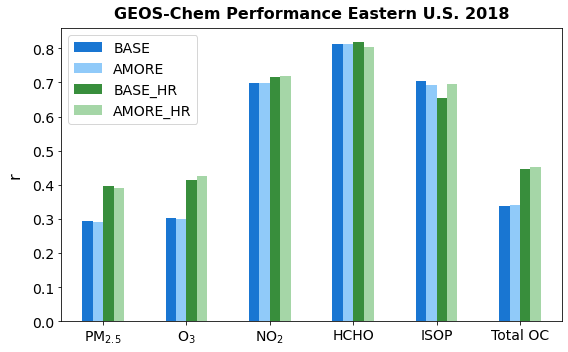

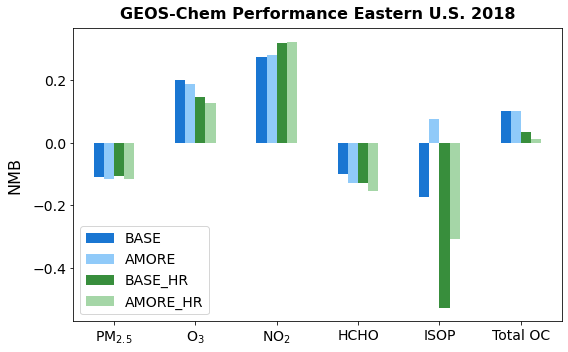

In [130]:
# Create bar charts with model performance statistics for BASE & AMORE for all variables
palette = ['#1976D2','#90CAF9','#388E3C','#A5D6A7']
var_label2 = ['$PM_{2.5}$','$O_{3}$','NO','$NO_{2}$','HCHO','ISOP','Total OC']

# Correlation coefficient (r)
r2_df = pd.DataFrame({'BASE':r2_base,'AMORE':r2_amore,'BASE_HR':r2_base_hr,'AMORE_HR':r2_amore_hr},index=var_label2)
fig12,ax12=plt.subplots(figsize=(8,5))
r2_df.drop('NO').plot.bar(ax=ax12,rot=0,color=palette)                 
#ax12.set_ylabel('$R^{2}$',fontsize='16',labelpad=10)
ax12.set_ylabel('r',fontsize='16',labelpad=10)
ax12.tick_params(axis='both', labelsize=14)
ax12.legend(loc='upper left',fontsize=14)
ax12.set_title('GEOS-Chem Performance Eastern U.S. 2018',fontsize='16',pad=10,fontweight='bold')
fig12.tight_layout()
fig12.savefig(fig_dir+'all_R2.png',dpi=300,bbox_inches='tight')

# Normalized mean bias (NMB)
nmb_df = pd.DataFrame({'BASE':nmb_base,'AMORE':nmb_amore,'BASE_HR':nmb_base_hr,'AMORE_HR':nmb_amore_hr},index=var_label2)
fig13,ax13=plt.subplots(figsize=(8,5))
nmb_df.drop('NO').plot.bar(ax=ax13,rot=0,color=palette)                 
ax13.set_ylabel('NMB',fontsize='16',labelpad=10)
ax13.tick_params(axis='both', labelsize=14)
ax13.legend(loc='lower left',fontsize=14)
ax13.set_title('GEOS-Chem Performance Eastern U.S. 2018',fontsize='16',pad=10,fontweight='bold')
fig13.tight_layout()
fig13.savefig(fig_dir+'all_NMB.png',dpi=300,bbox_inches='tight')

### Global + Regional Model Output (Species)

In [131]:
# Define variables
var_all = ['PM25','TotalOC','TotalBiogenicOA','AerMassSOAIE','SpeciesConc_ISOP','SpeciesConc_O3','SpeciesConc_OH','SpeciesConc_NO','SpeciesConc_NO2','SpeciesConc_NO3','SpeciesConc_HO2','SpeciesConc_CH2O','SpeciesConc_IDN','SpeciesConc_IHOO1','SpeciesConc_IDCHP','SpeciesConc_ICN','SpeciesConc_INPB','SpeciesConc_IHN1','SpeciesConc_IDC','SpeciesConc_IEPOXA']
var_label = ['$PM_{2.5}$ ($\mu$g $m^{-3}$)','Total OC ($\mu$g $m^{-3}$)','Biogenic OA ($\mu$g $m^{-3}$)','Aerosol-Phase IEPOX ($\mu$g $m^{-3}$)','Isoprene (ppb)','$O_{3}$ (ppb)','OH (ppt)','NO (ppb)','$NO_{2}$ (ppb)','$NO_{3}$ (ppt)','$HO_{2}$ (ppt)','HCHO (ppb)','ISON (ppt)','IHOO (ppt)','ISHP (ppt)','INO2 (ppt)','IPN (ppt)','IHN (ppt)','IPC (ppt)','IEPOX (ppt)']
vmin = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
vmax = [50,2,1,0.5,1,80,0.1,0.2,2,10,10,4,50,10,20,1000,70,60,50,800]
vdiff_min = [-2,-1,-2,-1,-6,-3,-0.025,-1,-0.2,-3,-3,-2,-200,-2,-1000,-700,-70,-60,-50,-400]
vdiff_max = [2,1,2,1,6,3,0.025,1,0.2,3,3,2,200,2,1000,700,70,60,50,400]
conv = [1,1,1,1,1e9,1e9,1e12,1e9,1e9,1e12,1e12,1e9,1e12,1e12,1e12,1e12,1e12,1e12,1e12,1e12] # multiply by number for unit conversion 

In [132]:
#pm_all = [] # entire model domain
#pm_all2 = [] # entire model domain
var_df = pd.DataFrame()
var_df2 = pd.DataFrame()
var_df3 = pd.DataFrame()
var_df4 = pd.DataFrame()
# Read model ouptut file
for i,v in enumerate(var_all):
    print(v)
    var_list = []
    var_list2 = []
    var_hr_list = []
    var_hr_list2 = []
    # Create figure directory if does not exist
    mkdir_p(fig_dir+v)
    for d in alldates:
        # Read in model output data
        if v[:7]=='Species':  
            n = 'GEOSChem.SpeciesConc.%s01_0000z.nc4'%d
        elif v[:3]=='Rxn':
            n = 'GEOSChem.RxnRates.%s01_0000z.nc4'%d
        else:
            n = 'GEOSChem.AerosolMass.%s01_0000z.nc4'%d
        nc = Dataset(data_dir+n,'r') # AMORE
        nc2 = Dataset(data_dir2+n,'r') # BASE
        nc11 = Dataset(data_dir11+n,'r') # BASE_HR
        nc12 = Dataset(data_dir12+n,'r') # AMORE_HR
        
        # Extract relevant variables
        var = nc.variables[v][0,0,:,:]*conv[i] # AMORE
        var2 = nc2.variables[v][0,0,:,:]*conv[i] # BASE
        var11 = nc11.variables[v][0,0,:,:]*conv[i] # BASE_HR
        var12 = nc12.variables[v][0,0,:,:]*conv[i] # AMORE_HR

        if (v==var_all[0] and d==alldates[0]):
            lat = nc.variables['lat'][:] # Latitude (degrees N)
            lon = nc.variables['lon'][:] # Longitude (degress E)
            lat_hr = nc12.variables['lat'][:] # Latitude (degrees N) -> HIGH-RES
            lon_hr = nc12.variables['lon'][:] # Longitude (degress E) -> HIGH-RES
            
        # Close the file
        nc.close()
        nc2.close()
        nc11.close()
        nc12.close()
        
        # Compute daily mean PM2.5 for entire domain
        var_list.append(var)
        var_list2.append(var2)
        var_hr_list.append(var11)
        var_hr_list2.append(var12)
        var_diff = var - var2
        var_range_diff = 'Min = %.2f, Max = %.2f, Mean = %.2f'%(np.min(var_diff),np.max(var_diff),np.mean(var_diff))
        var_diff2 = var_diff[57:69+1,32:45+1] # regional
        var_range_diff2 = 'Min = %.2f, Max = %.2f, Mean = %.2f'%(np.min(var_diff2),np.max(var_diff2),np.mean(var_diff2))
        print(d)
        ''' # uncomment to recreate monthly plots
        # Create monthly map of AMORE-BASE (DIFF) - GLOBAL
        fig1 = plt.figure(figsize=(12,8))
        m = Basemap(projection='cyl',llcrnrlon=lon.min(),llcrnrlat=lat.min(),urcrnrlon=lon.max(),urcrnrlat=lat.max(),resolution='c')
        x, y = m(*np.meshgrid(lon,lat))
        m.pcolormesh(x,y,var_diff,cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i])
        m.drawcoastlines()
        m.drawmapboundary()
        m.drawcountries()
        #cb = m.colorbar(location='right',extend='both')
        cb = m.colorbar(location='bottom',pad=0.6,extend='both')
        cb.ax.set_xlabel(var_label[i]+'  |  '+var_range_diff,fontsize=16,labelpad=-70)
        cb.ax.tick_params(labelsize=16)
        plt.title('DIFF (AMORE-BASE) GEOS-Chem %s-%s'%(d[:4],d[4:6]),fontsize=18,pad=20,fontweight='bold')
        fig1.savefig(fig_dir+'%s/global_map_diff_%s.png'%(v,d),dpi=300,bbox_inches='tight')
        plt.close()
        
        # Create monthly map of AMORE-BASE (DIFF) - REGIONAL
        fig2,ax2 = plt.subplots(figsize=(12,8))
        m = Basemap(projection='cyl',llcrnrlon=-100,llcrnrlat=24,urcrnrlon=-66,urcrnrlat=49,resolution='l')
        x, y = m(*np.meshgrid(lon,lat)) # model
        m.pcolormesh(x,y,var_diff,cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i]) # model
        m.drawcoastlines()
        m.drawmapboundary()
        m.drawcountries()
        cb = m.colorbar(location='bottom',pad=0.6,extend='both')
        cb.ax.set_xlabel(var_label[i]+'  |  '+var_range_diff2,fontsize=16,labelpad=-70)
        cb.ax.tick_params(labelsize=16)
        plt.title('DIFF (AMORE-BASE) GEOS-Chem %s-%s'%(d[:4],d[4:6]),fontsize=18,pad=20,fontweight='bold')
        fig2.tight_layout()
        fig2.savefig(fig_dir+'%s/us_map_DIFF_%s.png'%(v,d),dpi=300,bbox_inches='tight')
        plt.close()
        '''
    # Append to dataframes
    var_df[v] = var_list
    var_df2[v] = var_list2
    var_df3[v] = var_hr_list
    var_df4[v] = var_hr_list2

PM25
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
TotalOC
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
TotalBiogenicOA
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
AerMassSOAIE
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_ISOP
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_O3
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_OH
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_NO
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_NO2
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_NO3
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
SpeciesConc_HO2
201801
2

In [133]:
# Get nested grid lat/lon indices 
ilat = lat_hr[np.where((lat_hr>=27)&(lat_hr<=46))]
ilon = lon_hr[np.where((lon_hr>=-97)&(lon_hr<=-69))]

for i,v in enumerate(var_all):
    print(v)
    # Compute annual mean PM2.5
    var_avg = np.mean(var_df[v])
    var_avg2 = np.mean(var_df2[v])
    var_range = 'Min = %.2f, Max = %.2f, Mean = %.2f'%(np.min(var_avg),np.max(var_avg),np.mean(var_avg))
    var_range2 = 'Min = %.2f, Max = %.2f, Mean = %.2f'%(np.min(var_avg2),np.max(var_avg2),np.mean(var_avg2))
    var_diff = var_avg - var_avg2 # AMORE - BASE
    var_range_diff = 'Min = %.2f, Max = %.2f, Mean = %.2f'%(np.min(var_diff),np.max(var_diff),np.mean(var_diff))

    var_hr_avg = np.mean(var_df3[v]) # high-res
    var_hr_avg2 = np.mean(var_df4[v]) # high-res
    var_hr_diff = var_hr_avg2 - var_hr_avg # AMORE - BASE (HIGH-RES)
    var_diff2 = var_hr_diff[ilat.astype(int)][:,ilon.astype(int)]
    var_hr_diff_p = (var_hr_avg2 - var_hr_avg)/(var_hr_avg)*100 # AMORE - BASE (PERCENT DIFF)
    var_diff2_p = var_hr_diff_p[ilat.astype(int)][:,ilon.astype(int)]
    var_range_diff2 = 'Min = %.1f%%, Max = %.1f%%, Mean = %.1f%%'%(np.min(var_diff2_p),np.max(var_diff2_p),np.mean(var_diff2_p))

    # Create annual map of AMORE
    fig1,ax1 = plt.subplots(figsize=(12,8))
    #m = Basemap(projection='cyl',llcrnrlon=lon.min(),llcrnrlat=lat.min(),urcrnrlon=lon.max(),urcrnrlat=lat.max(),resolution='c')
    m = Basemap(projection='mill',llcrnrlon=lon.min(),llcrnrlat=-60,urcrnrlon=lon.max(),urcrnrlat=77,resolution='c')
    x, y = m(*np.meshgrid(lon,lat))
    m.pcolormesh(x,y,var_avg,cmap=plt.cm.YlOrRd,vmin=vmin[i],vmax=vmax[i])
    #m.contourf(x,y,pm_all_avg,cmap=plt.cm.viridis,levels=np.arange(0,350+5,1),vmin=0,vmax=350,extend='both')
    m.drawcoastlines(linewidth=1)
    m.drawmapboundary(linewidth=1)
    m.drawcountries()
    #cb = m.colorbar(location='right',extend='both')
    cb = m.colorbar(location='bottom',pad=0.6,extend='max')
    cb.ax.set_xlabel(var_label[i]+'  |  '+var_range,fontsize=16,labelpad=-70)
    cb.ax.tick_params(labelsize=16)
    plt.title('AMORE GEOS-Chem 2018',fontsize=18,pad=20,fontweight='bold')
    fig1.tight_layout()
    fig1.savefig(fig_dir+'%s/global_map_AMORE.png'%v,dpi=300,bbox_inches='tight')
    plt.close()
    
    # Create annual map of BASE
    fig2,ax2 = plt.subplots(figsize=(12,8))
    #m = Basemap(projection='cyl',llcrnrlon=lon.min(),llcrnrlat=lat.min(),urcrnrlon=lon.max(),urcrnrlat=lat.max(),resolution='c')
    m = Basemap(projection='mill',llcrnrlon=lon.min(),llcrnrlat=-60,urcrnrlon=lon.max(),urcrnrlat=77,resolution='c')
    x, y = m(*np.meshgrid(lon,lat))
    m.pcolormesh(x,y,var_avg2,cmap=plt.cm.YlOrRd,vmin=vmin[i],vmax=vmax[i])
    #m.contourf(x,y,pm_all_avg2,cmap=plt.cm.viridis,levels=np.arange(0,350+5,1),vmin=0,vmax=350,extend='both')
    m.drawcoastlines(linewidth=1)
    m.drawmapboundary(linewidth=1)
    m.drawcountries()
    #cb = m.colorbar(location='right',extend='both')
    cb = m.colorbar(location='bottom',pad=0.6,extend='max')
    cb.ax.set_xlabel(var_label[i]+'  |  '+var_range2,fontsize=16,labelpad=-70)
    cb.ax.tick_params(labelsize=16)
    plt.title('BASE GEOS-Chem 2018',fontsize=18,pad=20,fontweight='bold')
    fig2.tight_layout()
    fig2.savefig(fig_dir+'%s/global_map_BASE.png'%v,dpi=300,bbox_inches='tight')
    plt.close()
    
    # Create annual map of AMORE-BASE (DIFF) - GLOBAL
    fig3,ax3 = plt.subplots(figsize=(12,8))
    #m = Basemap(projection='cyl',llcrnrlon=lon.min(),llcrnrlat=lat.min(),urcrnrlon=lon.max(),urcrnrlat=lat.max(),resolution='c')
    m = Basemap(projection='mill',llcrnrlon=lon.min(),llcrnrlat=-60,urcrnrlon=lon.max(),urcrnrlat=77,resolution='c')
    x, y = m(*np.meshgrid(lon,lat))
    m.pcolormesh(x,y,var_diff,cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i])
    #m.contourf(x,y,pm_all_avg,cmap=plt.cm.viridis,levels=np.arange(0,350+5,1),vmin=0,vmax=350,extend='both')
    m.drawcoastlines(linewidth=1)
    m.drawmapboundary(linewidth=1)
    m.drawcountries()
    # Plot southeast U.S. study region bounding box
    x1,y1 = m(-97,27) ##### SE corner lon/lat
    x2,y2 = m(-97,46) ##### NE corner lon/lat
    x3,y3 = m(-69,46) ##### NW corner lon/lat
    x4,y4 = m(-69,27) ##### SW corner lon/lat
    poly = Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],facecolor='none',edgecolor='g',linewidth=2.5) #####
    ax3.add_patch(poly) #####
    #cb = m.colorbar(location='right',extend='both')
    cb = m.colorbar(location='bottom',pad=0.6,extend='both')
    cb.ax.set_xlabel(var_label[i]+'  |  '+var_range_diff,fontsize=16,labelpad=-70)
    cb.ax.tick_params(labelsize=16)
    plt.title('DIFF (AMORE-BASE) GEOS-Chem 2018',fontsize=18,pad=20,fontweight='bold')
    fig3.tight_layout()
    fig3.savefig(fig_dir+'%s/global_map_DIFF.png'%v,dpi=300,bbox_inches='tight')
    plt.close()
    
    # Create annual map of AMORE-BASE (DIFF) - REGIONAL
    fig4,ax4 = plt.subplots(figsize=(12,8))
    m = Basemap(projection='mill',llcrnrlon=-97,llcrnrlat=27,urcrnrlon=-69,urcrnrlat=46,resolution='l')
    x, y = m(*np.meshgrid(lon_hr,lat_hr)) # model
    m.pcolormesh(x,y,var_hr_diff,cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i]) # model
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()
    cb = m.colorbar(location='bottom',pad=0.6,extend='both')
    cb.ax.set_xlabel(var_label[i]+'  |  '+var_range_diff2,fontsize=16,labelpad=-70)
    cb.ax.tick_params(labelsize=16)
    plt.title('DIFF (AMORE_HR-BASE_HR) GEOS-Chem 2018',fontsize=18,pad=20,fontweight='bold')
    fig4.tight_layout()
    fig4.savefig(fig_dir+'%s/us_map_DIFF.png'%v,dpi=300,bbox_inches='tight')
    plt.close()

PM25
TotalOC
TotalBiogenicOA
AerMassSOAIE
SpeciesConc_ISOP
SpeciesConc_O3
SpeciesConc_OH
SpeciesConc_NO
SpeciesConc_NO2
SpeciesConc_NO3
SpeciesConc_HO2
SpeciesConc_CH2O
SpeciesConc_IDN
SpeciesConc_IHOO1
SpeciesConc_IDCHP
SpeciesConc_ICN
SpeciesConc_INPB
SpeciesConc_IHN1
SpeciesConc_IDC
SpeciesConc_IEPOXA


### Global + Regional Model Output (Reaction Rates)

In [35]:
var_amore = ['001','002','003','004','005','006','007','008','009','010','011','012','013','014','015','016','017','018','019','020','021','310','566','567','594']
var_base = ['289','384','385','386','387','388','389','390','403','404','407','408','409','410','419','421','442','443','444','445','446','469','470','473','494','495','496','506','507','508','509','532','578','723','724','725','741','894']

In [36]:
var_df = pd.DataFrame()
var_df2 = pd.DataFrame()
# Read model ouptut file
for j in [1,2]:
    if j==1:
        var_all = var_amore
    elif j==2:
        var_all = var_base
    for i,v in enumerate(var_all):
        v = 'RxnRate_EQ'+v
        print(v)
        var_list = []
        # Create figure directory if does not exist
        if j==1:
            mkdir_p(fig_dir+'RxnRates/AMORE/'+v)
        elif j==2:
            mkdir_p(fig_dir+'RxnRates/BASE/'+v)
        for d in alldates:
            if j==1:
                nc = Dataset(data_dir+'GEOSChem.RxnRates.%s01_0000z.nc4'%d,'r') # AMORE
            elif j==2:
                nc = Dataset(data_dir2+'GEOSChem.RxnRates.%s01_0000z.nc4'%d,'r') # BASE

            # Extract relevant variables
            var = nc.variables[v][0,0,:,:]

            if (v==var_all[0] and d==alldates[0]):
                lat = nc.variables['lat'][:] # Latitude (degrees N)
                lon = nc.variables['lon'][:] # Longitude (degress E)

            # Close the file
            nc.close()

            # Compute daily mean PM2.5 for entire domain
            var_list.append(var)

            '''
            # Create monthly map of AMORE-BASE (DIFF) - GLOBAL
            fig1 = plt.figure(figsize=(12,8))
            m = Basemap(projection='cyl',llcrnrlon=lon.min(),llcrnrlat=lat.min(),urcrnrlon=lon.max(),urcrnrlat=lat.max(),resolution='c')
            x, y = m(*np.meshgrid(lon,lat))
            m.pcolormesh(x,y,var_diff,cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i])
            m.drawcoastlines()
            m.drawmapboundary()
            m.drawcountries()
            #cb = m.colorbar(location='right',extend='both')
            cb = m.colorbar(location='bottom',pad=0.6,extend='both')
            cb.ax.set_xlabel(var_label[i]+'  |  '+var_range_diff,fontsize=16,labelpad=-70)
            cb.ax.tick_params(labelsize=16)
            plt.title('DIFF (AMORE-BASE) GEOS-Chem %s-%s'%(d[:4],d[4:6]),fontsize=18,pad=20,fontweight='bold')
            fig1.savefig(fig_dir+'%s/global_map_diff_%s.png'%(v,d),dpi=300,bbox_inches='tight')
            plt.close()

            # Create monthly map of AMORE-BASE (DIFF) - REGIONAL
            fig2,ax2 = plt.subplots(figsize=(12,8))
            m = Basemap(projection='cyl',llcrnrlon=-100,llcrnrlat=24,urcrnrlon=-66,urcrnrlat=49,resolution='l')
            x, y = m(*np.meshgrid(lon,lat)) # model
            m.pcolormesh(x,y,var_diff,cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i]) # model
            m.drawcoastlines()
            m.drawmapboundary()
            m.drawcountries()
            cb = m.colorbar(location='bottom',pad=0.6,extend='max')
            cb.ax.set_xlabel(var_label[i]+'  |  '+var_range_diff2,fontsize=16,labelpad=-70)
            cb.ax.tick_params(labelsize=16)
            plt.title('DIFF (AMORE-BASE) GEOS-Chem %s-%s'%(d[:4],d[4:6]),fontsize=18,pad=20,fontweight='bold')
            fig2.tight_layout()
            fig2.savefig(fig_dir+'%s/us_map_DIFF_%s.png'%(v,d),dpi=300,bbox_inches='tight')
            plt.close()
            '''
        # Append to dataframes
        if j==1:
            var_df[v] = var_list
        elif j==2:
            var_df2[v] = var_list

RxnRate_EQ001
RxnRate_EQ002
RxnRate_EQ003
RxnRate_EQ004
RxnRate_EQ005
RxnRate_EQ006
RxnRate_EQ007
RxnRate_EQ008
RxnRate_EQ009
RxnRate_EQ010
RxnRate_EQ011
RxnRate_EQ012
RxnRate_EQ013
RxnRate_EQ014
RxnRate_EQ015
RxnRate_EQ016
RxnRate_EQ017
RxnRate_EQ018
RxnRate_EQ019
RxnRate_EQ020
RxnRate_EQ021
RxnRate_EQ310
RxnRate_EQ566
RxnRate_EQ567
RxnRate_EQ594
RxnRate_EQ289
RxnRate_EQ384
RxnRate_EQ385
RxnRate_EQ386
RxnRate_EQ387
RxnRate_EQ388
RxnRate_EQ389
RxnRate_EQ390
RxnRate_EQ403
RxnRate_EQ404
RxnRate_EQ407
RxnRate_EQ408
RxnRate_EQ409
RxnRate_EQ410
RxnRate_EQ419
RxnRate_EQ421
RxnRate_EQ442
RxnRate_EQ443
RxnRate_EQ444
RxnRate_EQ445
RxnRate_EQ446
RxnRate_EQ469
RxnRate_EQ470
RxnRate_EQ473
RxnRate_EQ494
RxnRate_EQ495
RxnRate_EQ496
RxnRate_EQ506
RxnRate_EQ507
RxnRate_EQ508
RxnRate_EQ509
RxnRate_EQ532
RxnRate_EQ578
RxnRate_EQ723
RxnRate_EQ724
RxnRate_EQ725
RxnRate_EQ741
RxnRate_EQ894


In [ ]:
for j in [1,2]:
    if j==1:
        var_all = var_amore
    elif j==2:
        var_all = var_base
    for i,v in enumerate(var_all):
        v = 'RxnRate_EQ'+v
        print(v)
        # Compute annual mean PM2.5
        if j==1:
            var_avg = np.mean(var_df[v])
        elif j==2:
            var_avg = np.mean(var_df2[v])
        #var_avg2 = np.mean(var_df2[v])
        var_range = 'Min = %.2f, Max = %.2f, Mean = %.2f'%(np.min(var_avg),np.max(var_avg),np.mean(var_avg))
        #var_range2 = 'Min = %.1f, Max = %.1f, Mean = %.1f'%(np.min(var_avg2),np.max(var_avg2),np.mean(var_avg2))
        #var_diff = var_avg - var_avg2 # AMORE - BASE
        #var_range_diff = 'Min = %.1f, Max = %.1f, Mean = %.1f'%(np.min(var_diff),np.max(var_diff),np.mean(var_diff))
        #var_diff2 = var_diff[57:69+1,32:45+1] # regional
        #var_range_diff2 = 'Min = %.1f, Max = %.1f, Mean = %.1f'%(np.min(var_diff2),np.max(var_diff2),np.mean(var_diff2))

        # Create annual map of AMORE
        fig1,ax1 = plt.subplots(figsize=(12,8))
        m = Basemap(projection='cyl',llcrnrlon=lon.min(),llcrnrlat=lat.min(),urcrnrlon=lon.max(),urcrnrlat=lat.max(),resolution='c')
        #m = Basemap(projection='moll',lon_0=np.mean(lon),resolution='c')
        x, y = m(*np.meshgrid(lon,lat))
        m.pcolormesh(x,y,var_avg,cmap=plt.cm.YlOrRd)
        #m.contourf(x,y,pm_all_avg,cmap=plt.cm.viridis,levels=np.arange(0,350+5,1),vmin=0,vmax=350,extend='both')
        m.drawcoastlines(linewidth=1)
        m.drawmapboundary(linewidth=1)
        m.drawcountries()
        #cb = m.colorbar(location='right',extend='both')
        cb = m.colorbar(location='bottom',pad=0.6,extend='max')
        cb.ax.set_xlabel(v+' ($s^{-1}$)'+'  |  '+var_range,fontsize=16,labelpad=-70)
        cb.ax.tick_params(labelsize=16)
        if j==1:
            plt.title('AMORE GEOS-Chem 2018',fontsize=18,pad=20,fontweight='bold')
            fig1.tight_layout()
            fig1.savefig(fig_dir+'RxnRates/AMORE/'+'%s_global_map_AMORE.png'%v,dpi=300,bbox_inches='tight')
        elif j==2:
            plt.title('BASE GEOS-Chem 2018',fontsize=18,pad=20,fontweight='bold')
            fig1.tight_layout()
            fig1.savefig(fig_dir+'RxnRates/BASE/'+'%s_global_map_BASE.png'%v,dpi=300,bbox_inches='tight')
        '''
        # Create annual map of BASE
        fig2,ax2 = plt.subplots(figsize=(12,8))
        m = Basemap(projection='cyl',llcrnrlon=lon.min(),llcrnrlat=lat.min(),urcrnrlon=lon.max(),urcrnrlat=lat.max(),resolution='c')
        #m = Basemap(projection='moll',lon_0=np.mean(lon),resolution='c')
        x, y = m(*np.meshgrid(lon,lat))
        m.pcolormesh(x,y,var_avg2,cmap=plt.cm.YlOrRd,vmin=vmin[i],vmax=vmax[i])
        #m.contourf(x,y,pm_all_avg2,cmap=plt.cm.viridis,levels=np.arange(0,350+5,1),vmin=0,vmax=350,extend='both')
        m.drawcoastlines(linewidth=1)
        m.drawmapboundary(linewidth=1)
        m.drawcountries()
        #cb = m.colorbar(location='right',extend='both')
        cb = m.colorbar(location='bottom',pad=0.6,extend='max')
        cb.ax.set_xlabel(var_label[i]+'  |  '+var_range2,fontsize=16,labelpad=-70)
        cb.ax.tick_params(labelsize=16)
        plt.title('BASE GEOS-Chem 2018',fontsize=18,pad=20,fontweight='bold')
        fig2.tight_layout()
        fig2.savefig(fig_dir+'%s/global_map_BASE.png'%v,dpi=300,bbox_inches='tight')

        # Create annual map of AMORE-BASE (DIFF) - GLOBAL
        fig3,ax3 = plt.subplots(figsize=(12,8))
        m = Basemap(projection='cyl',llcrnrlon=lon.min(),llcrnrlat=lat.min(),urcrnrlon=lon.max(),urcrnrlat=lat.max(),resolution='c')
        #m = Basemap(projection='moll',lon_0=np.mean(lon),resolution='c')
        x, y = m(*np.meshgrid(lon,lat))
        m.pcolormesh(x,y,var_diff,cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i])
        #m.contourf(x,y,pm_all_avg,cmap=plt.cm.viridis,levels=np.arange(0,350+5,1),vmin=0,vmax=350,extend='both')
        m.drawcoastlines(linewidth=1)
        m.drawmapboundary(linewidth=1)
        m.drawcountries()
        #cb = m.colorbar(location='right',extend='both')
        cb = m.colorbar(location='bottom',pad=0.6,extend='both')
        cb.ax.set_xlabel(var_label[i]+'  |  '+var_range_diff,fontsize=16,labelpad=-70)
        cb.ax.tick_params(labelsize=16)
        plt.title('DIFF (AMORE-BASE) GEOS-Chem 2018',fontsize=18,pad=20,fontweight='bold')
        fig3.tight_layout()
        fig3.savefig(fig_dir+'%s/global_map_DIFF.png'%v,dpi=300,bbox_inches='tight')

        # Create annual map of AMORE-BASE (DIFF) - REGIONAL
        fig4,ax4 = plt.subplots(figsize=(12,8))
        m = Basemap(projection='cyl',llcrnrlon=-100,llcrnrlat=24,urcrnrlon=-66,urcrnrlat=49,resolution='l')
        x, y = m(*np.meshgrid(lon,lat)) # model
        m.pcolormesh(x,y,var_diff,cmap=plt.cm.seismic,vmin=vdiff_min[i],vmax=vdiff_max[i]) # model
        m.drawcoastlines()
        m.drawmapboundary()
        m.drawcountries()
        cb = m.colorbar(location='bottom',pad=0.6,extend='max')
        cb.ax.set_xlabel(var_label[i]+'  |  '+var_range_diff2,fontsize=16,labelpad=-70)
        cb.ax.tick_params(labelsize=16)
        plt.title('DIFF (AMORE-BASE) GEOS-Chem 2018',fontsize=18,pad=20,fontweight='bold')
        fig4.tight_layout()
        fig4.savefig(fig_dir+'%s/us_map_DIFF.png'%v,dpi=300,bbox_inches='tight')
        plt.close()
        '''